# Прогнозирование оттока клиентов телеком-компании

## Описание проекта
Прогнозная модель для выявления клиентов с высоким риском оттока с целью проактивного удержания 

## Бизнес задача
Снижение оттока клиентов через персонализированные удержательные меры 

## Ключевые результаты
- **Recall 87%** - находим 87% уходящих клиентов
- **Precision 50%** - каждый второй предсказанный реально уйдет
- **Оптимальный порог 0.475** - баланс между recall и precision
- **Топ-факторы оттока**: временный клиент, помесячный контракт, интернет провайдер "fiber" и не подключен ни один сервис

## Структура проекта 
- `notebooks/churn_analysis.ipynb` - полный анализ
- `models/xgb_model.pkl` - сохраненная модель
- `predict.py` - функция для предсказаний
- `requirements.txt` - зависимости

## 1. Импорт библиотек и загрузка данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
churn_df = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

customerID - уникальный айди 

gender - пол 

SeniorCitizen - пожилой человек (0/1)

Partner	- есть ли партнер (yes/no)

Dependents - есть ли иждивенцы (yes/no)

tenure - кол-во месяцев в течение которых клиент сотрудничал с компанией 

PhoneService - наличие телефона. Есть ли у клиента телефонная связь (yes/no)

MultipleLines - есть ли у клиента много номеров (yes/no/no phone service) No phone service - нет телефонной связи 

InternetService	- интернет провайдер клиента 

OnlineSecurity - есть ли у клиента онлайн защита (yes/no/No internet service)  No internet service - нет доступа в интернет 

OnlineBackup - есть ли у клиента онлайн резервное копирование (yes/no/No internet service)  No internet service - нет доступа в интернет 

DeviceProtection - есть ли у клиента защита устройств (yes/no/No internet service)  No internet service - нет доступа в интернет 

TechSupport	- есть ли у клиента техническая поддержка (yes/no/No internet service)  No internet service - нет доступа в интернет 

StreamingTV	- есть ли у клиента доступ к стриминговому телевидению (yes/no/No internet service)  No internet service - нет доступа в интернет 

StreamingMovies	- есть ли у клиента доступ к стриминговым фильмам (yes/no/No internet service)  No internet service - нет доступа в интернет 

Contract - срок действия контракта с клиентом (Month-to-month, One year, Two year)

PaperlessBilling - есть ли у клиента возможность бумажного биллинга (может ли клиент получать счета на бумаге. yes/no) 

PaymentMethod - способ оплаты (Electronic check, Mailed check, Bank transfer (automatic), Credit card)

MonthlyCharges - сумма, взимаемая с клиента ежемесячно 

TotalCharges - общая сумма, подлежащая оплате клиентом

Churn - ушел ли клиент (yes/no) - целевая переменная 

In [3]:
churn_df

customerID  gender  SeniorCitizen Partner Dependents  tenure  \
0     7590-VHVEG  Female              0     Yes         No       1   
1     5575-GNVDE    Male              0      No         No      34   
2     3668-QPYBK    Male              0      No         No       2   
3     7795-CFOCW    Male              0      No         No      45   
4     9237-HQITU  Female              0      No         No       2   
...          ...     ...            ...     ...        ...     ...   
7038  6840-RESVB    Male              0     Yes        Yes      24   
7039  2234-XADUH  Female              0     Yes        Yes      72   
7040  4801-JZAZL  Female              0     Yes        Yes      11   
7041  8361-LTMKD    Male              1     Yes         No       4   
7042  3186-AJIEK    Male              0      No         No      66   

     PhoneService     MultipleLines InternetService OnlineSecurity  ...  \
0              No  No phone service             DSL             No  ...   
1             Yes                No             DSL            Yes  ...   
2             Yes                No             DSL            Yes  ...   
3              No  No phone service             DSL            Yes  ...   
4             Yes                No     Fiber optic             No  ...   
...           ...               ...             ...            ...  ...   
7038          Yes               Yes             DSL            Yes  ...   
7039          Yes               Yes     Fiber optic             No  ...   
7040           No  No phone service             DSL            Yes  ...   
7041          Yes               Yes     Fiber optic             No  ...   
7042          Yes                No     Fiber optic            Yes  ...   

     DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0                  No          No          No              No  Month-to-month   
1                 Yes          No          No              No        One year   
2                  No          No          No              No  Month-to-month   
3                 Yes         Yes          No              No        One year   
4                  No          No          No              No  Month-to-month   
...               ...         ...         ...             ...             ...   
7038              Yes         Yes         Yes             Yes        One year   
7039              Yes          No         Yes             Yes        One year   
7040               No          No          No              No  Month-to-month   
7041               No          No          No              No  Month-to-month   
7042              Yes         Yes         Yes             Yes        Two year   

     PaperlessBilling              PaymentMethod MonthlyCharges  TotalCharges  \
0                 Yes           Electronic check          29.85         29.85   
1                  No               Mailed check          56.95        1889.5   
2                 Yes               Mailed check          53.85        108.15   
3                  No  Bank transfer (automatic)          42.30       1840.75   
4                 Yes           Electronic check          70.70        151.65   
...               ...                        ...            ...           ...   
7038              Yes               Mailed check          84.80        1990.5   
7039              Yes    Credit card (automatic)         103.20        7362.9   
7040              Yes           Electronic check          29.60        346.45   
7041              Yes               Mailed check          74.40         306.6   
7042              Yes  Bank transfer (automatic)         105.65        6844.5   

     Churn  
0       No  
1       No  
2      Yes  
3       No  
4      Yes  
...    ...  
7038    No  
7039    No  
7040    No  
7041   Yes  
7042    No  

[7043 rows x 21 columns]

## 2. Exploratory Data Analysis (EDA)
### 2.1 Первичный анализ данных

In [4]:
churn_df.describe()

SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000

In [5]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
churn_df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

<AxesSubplot:xlabel='Churn', ylabel='count'>

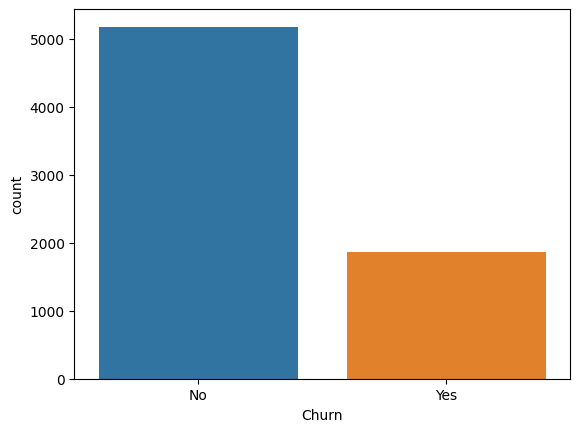

In [7]:
sns.countplot(data=churn_df, x='Churn')

In [8]:
len(churn_df['customerID'].unique()) # Все айди уникальные

7043

### Вывод: нет пропусков, TotalCharges - object (должен быть float), дисбаланс классов

### 2.2 Анализ категориальных признаков

In [9]:
cat_features = [col for col in churn_df.columns if len(churn_df[col].unique()) < 10]
cat_features

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

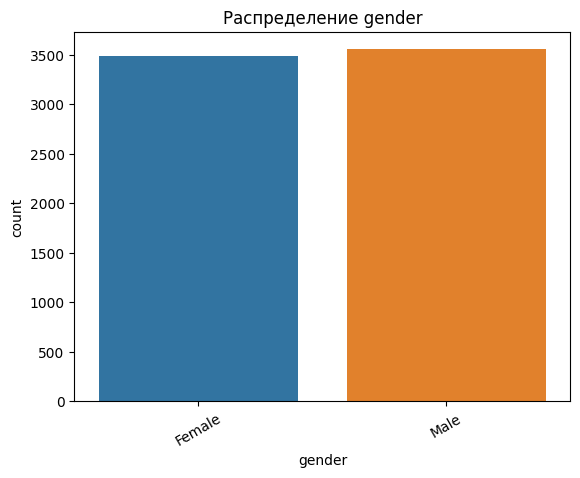

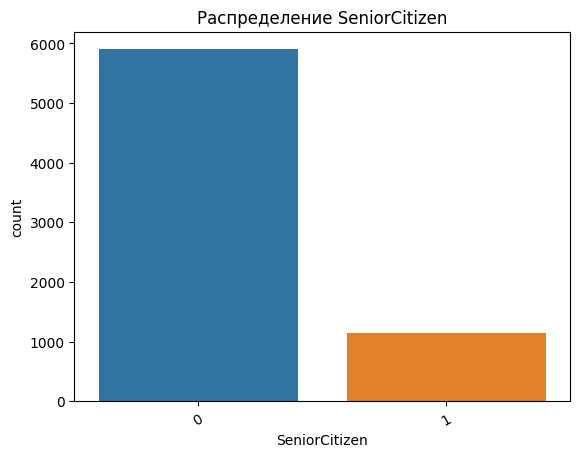

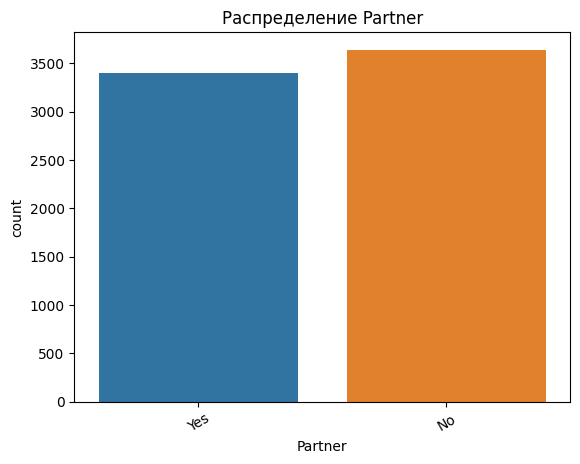

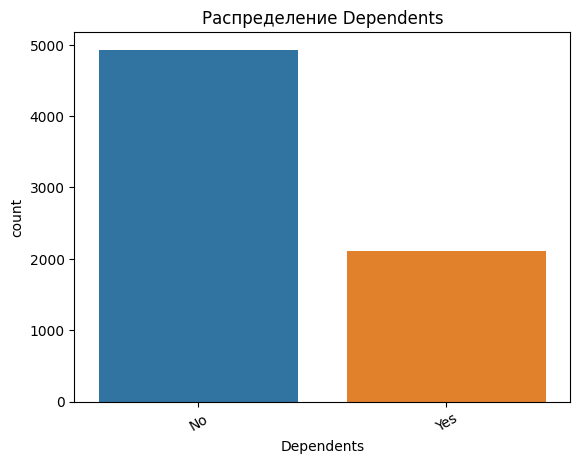

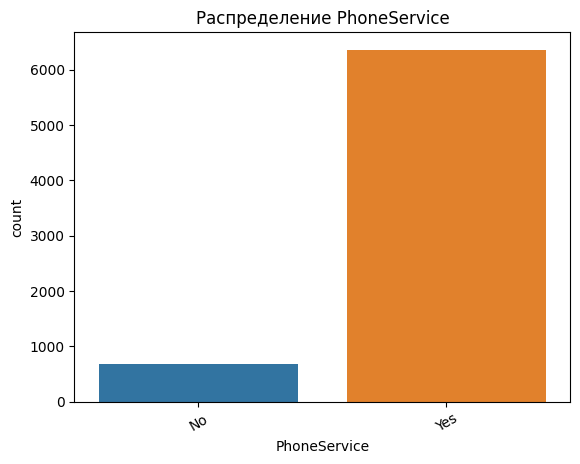

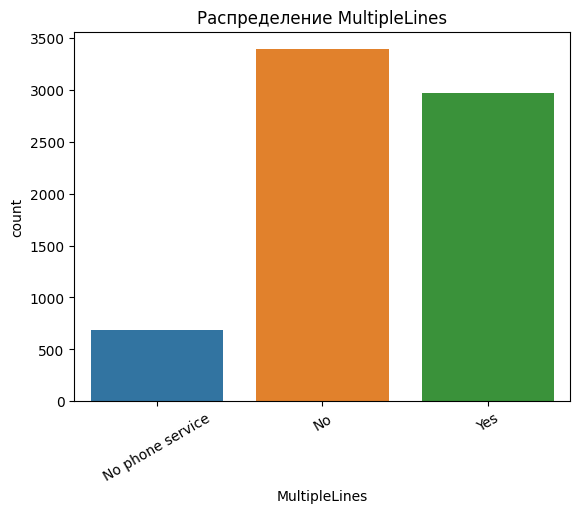

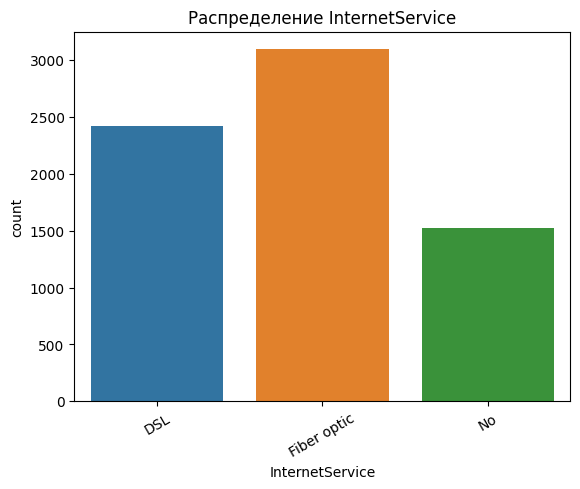

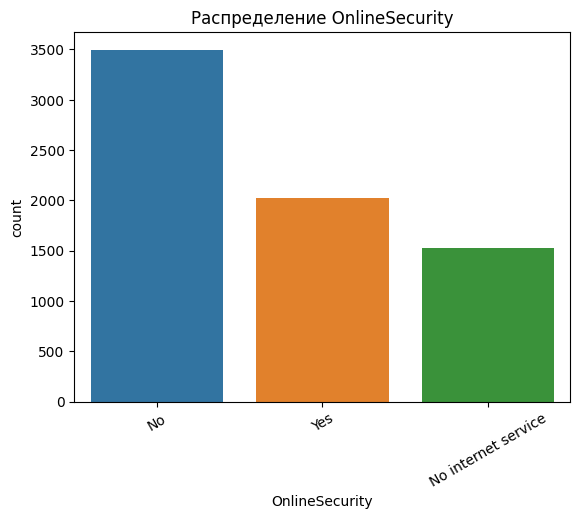

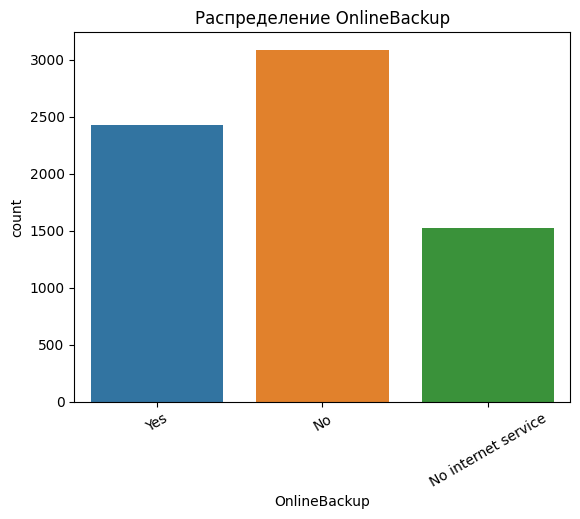

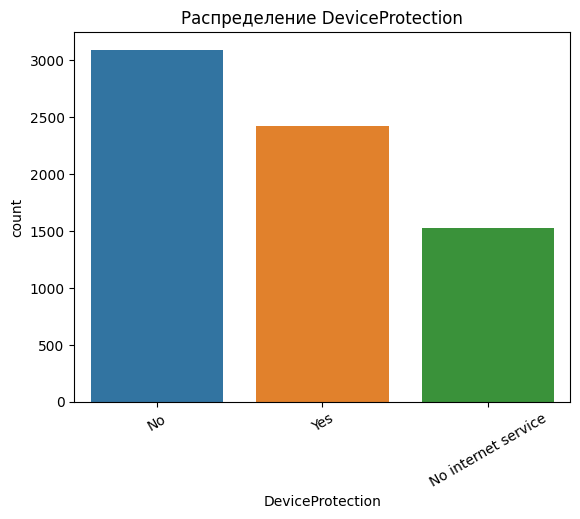

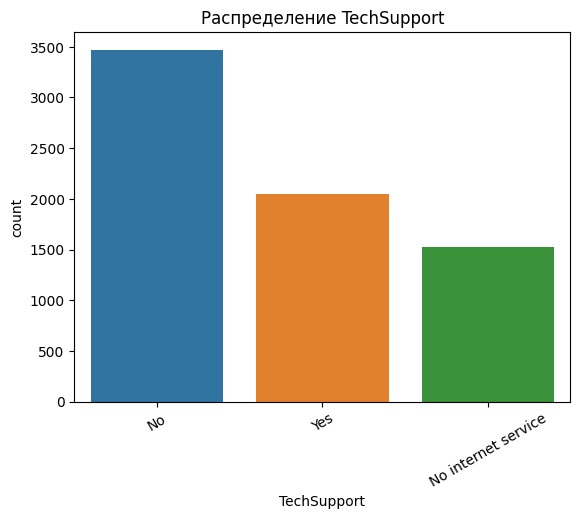

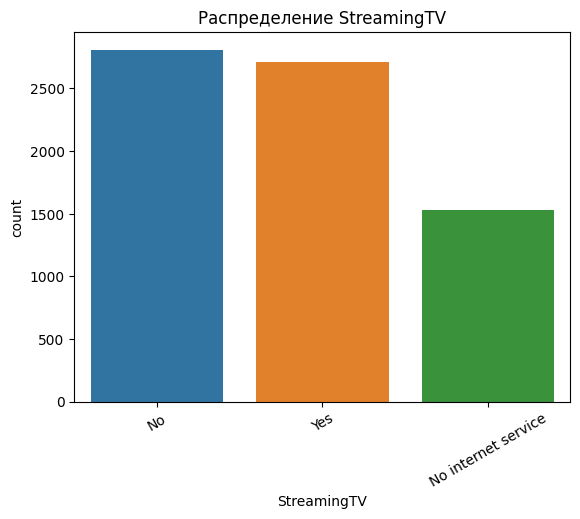

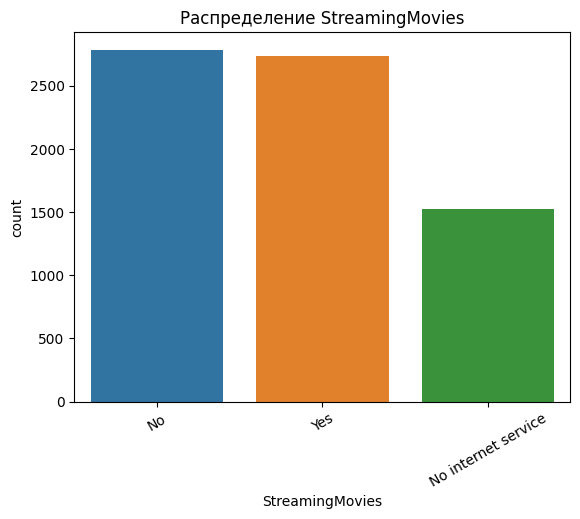

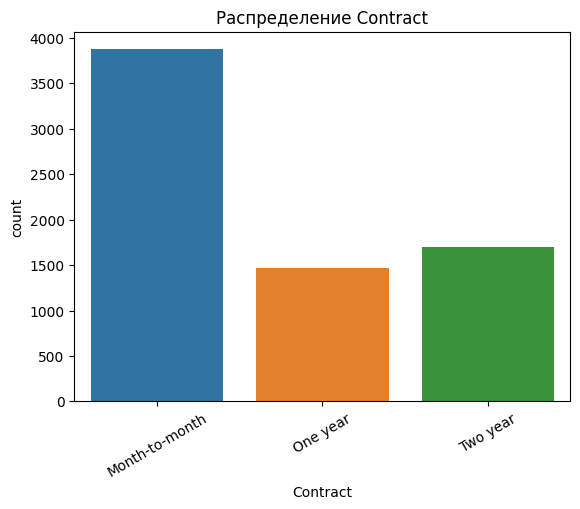

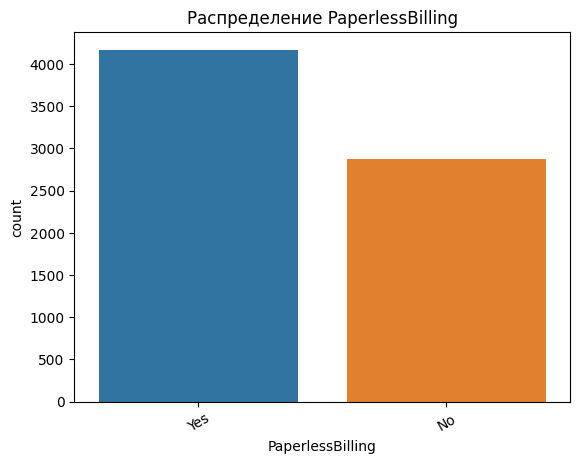

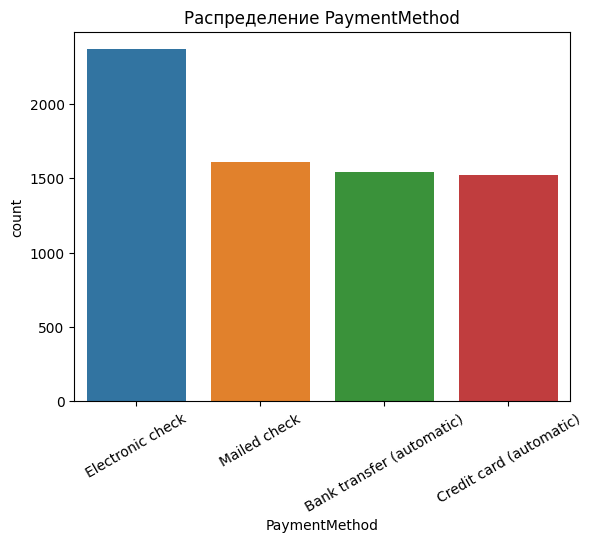

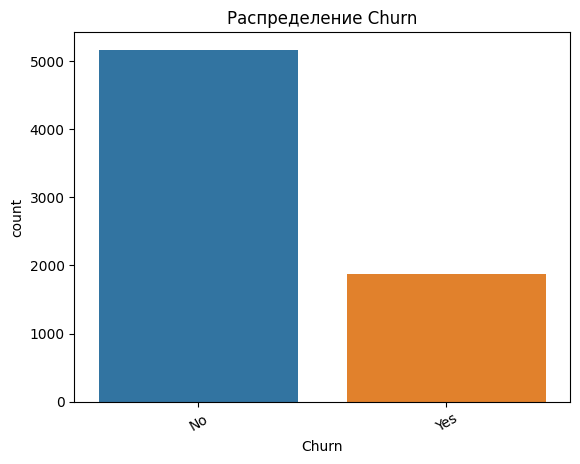

In [10]:
for feature in cat_features:
    sns.countplot(data=churn_df, x=feature)
    plt.title(f'Распределение {feature}')
    plt.xticks(rotation=30)
    plt.show()

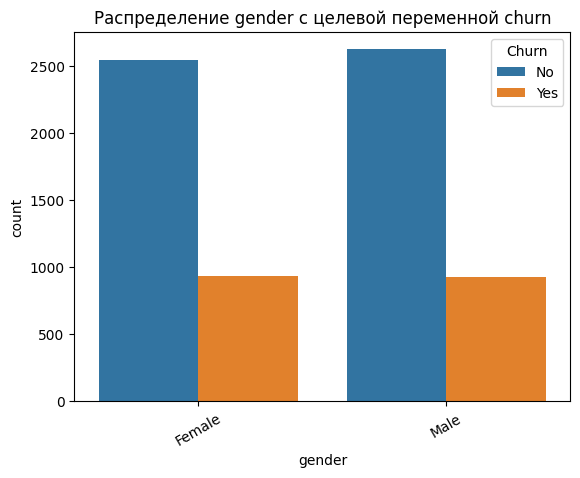

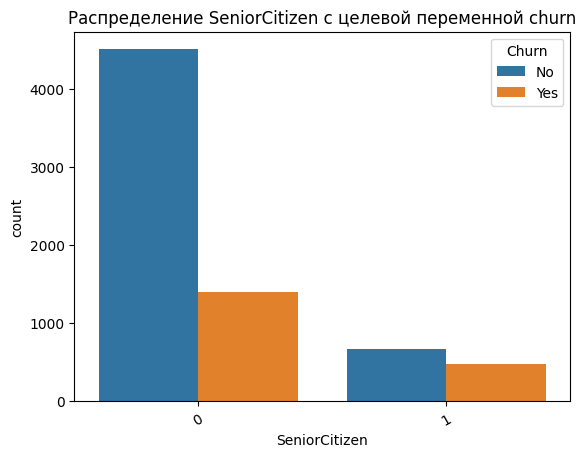

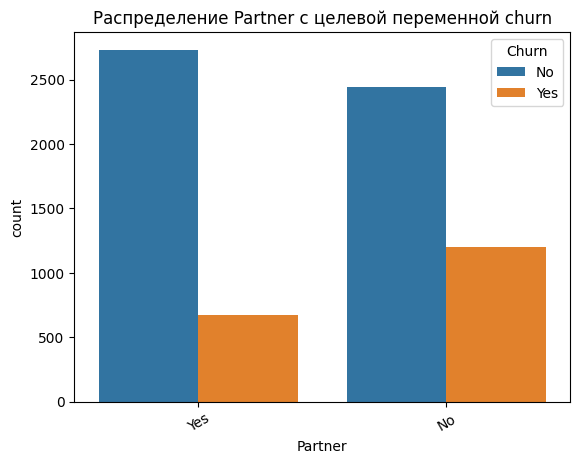

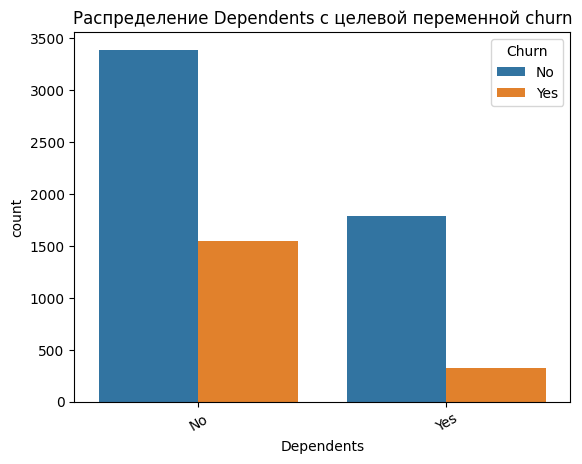

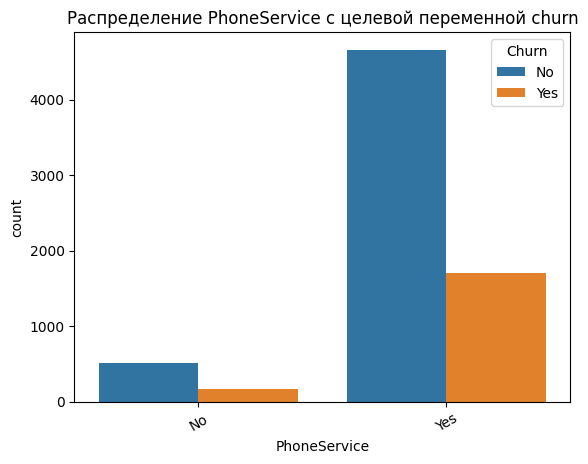

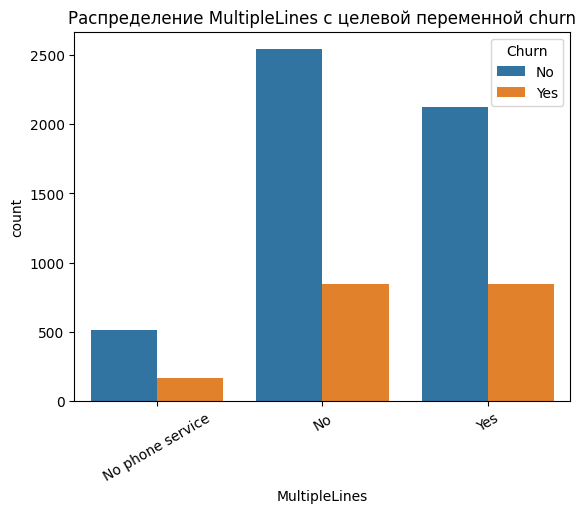

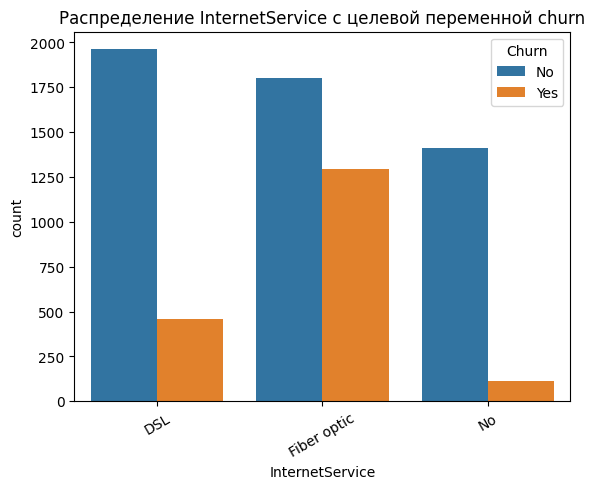

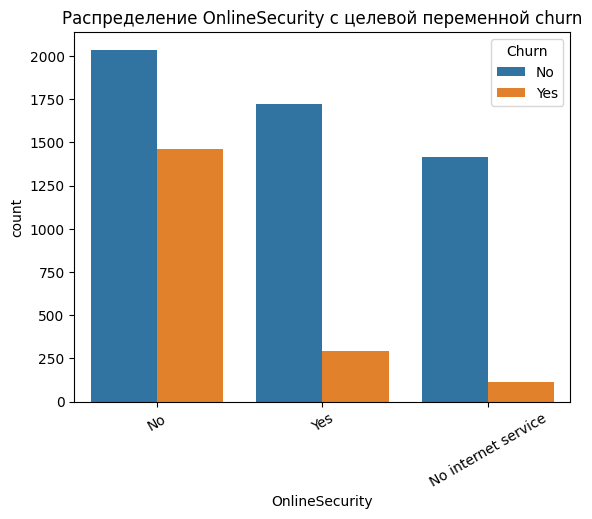

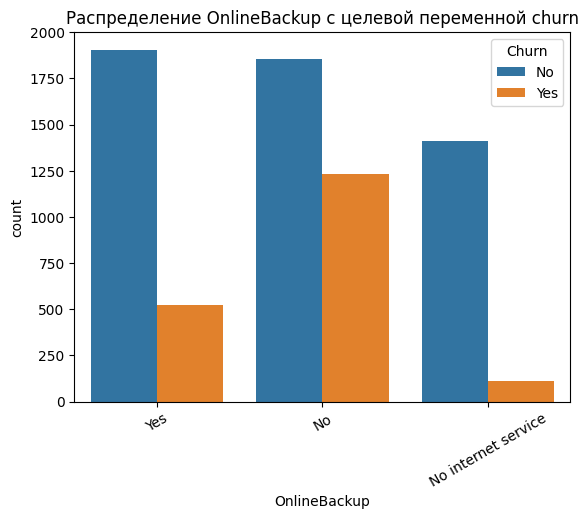

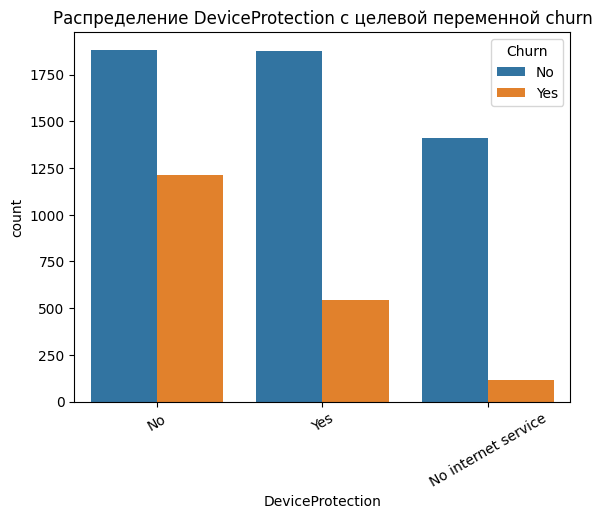

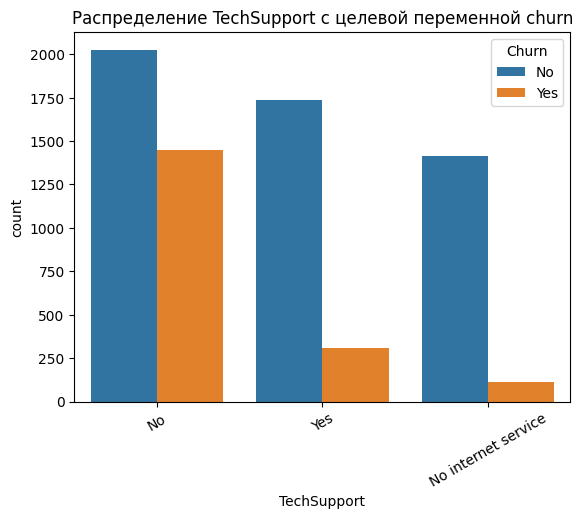

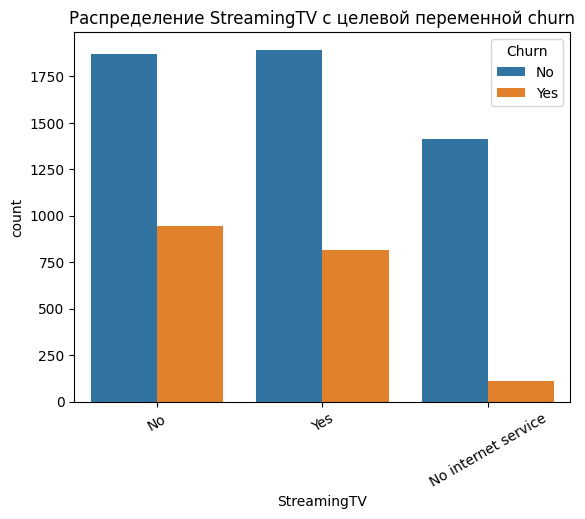

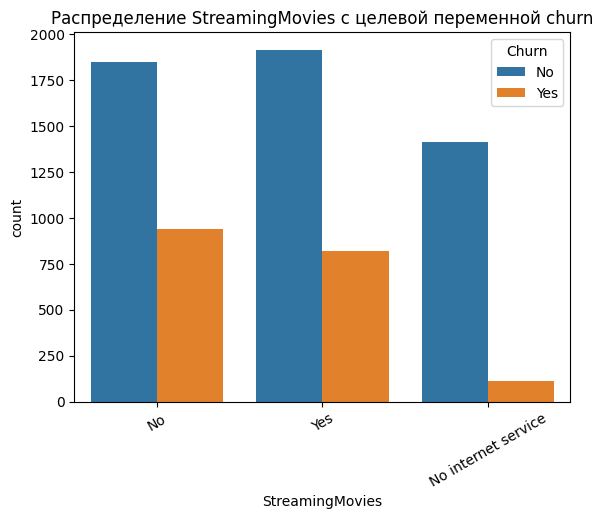

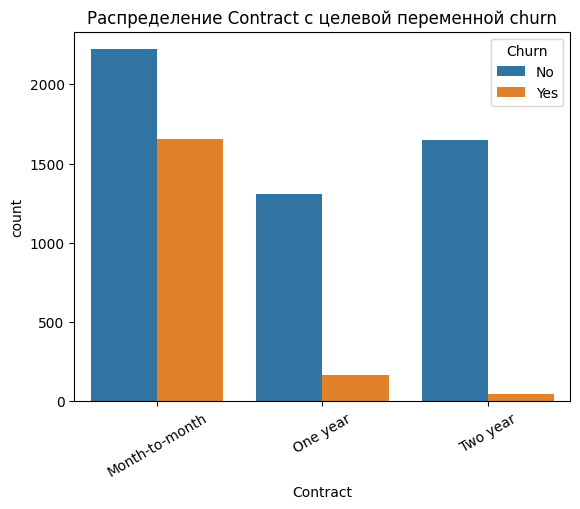

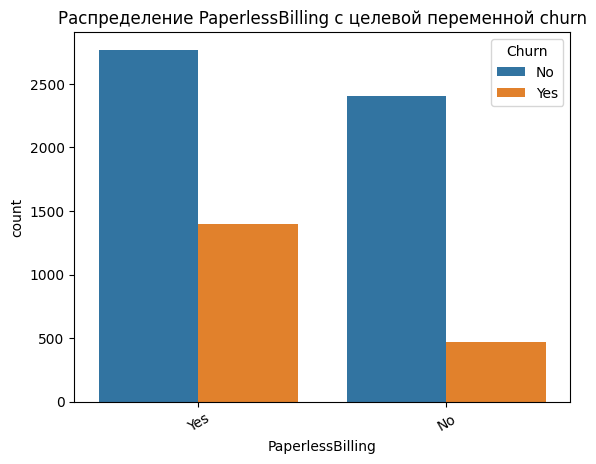

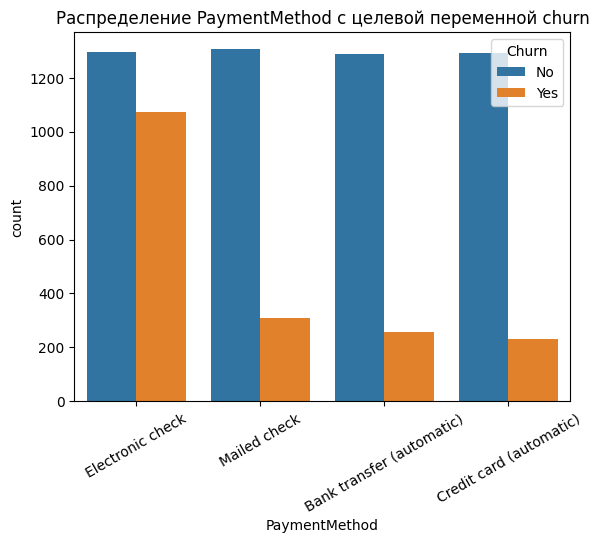

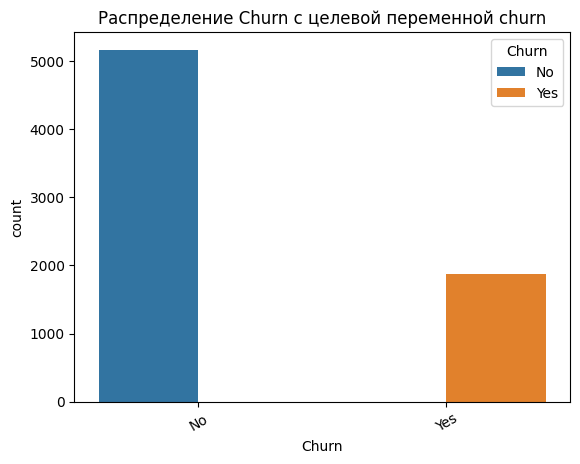

In [11]:
for feature in cat_features:
    sns.countplot(data=churn_df, x=feature, hue='Churn')
    plt.title(f'Распределение {feature} с целевой переменной churn')
    plt.xticks(rotation=30)
    plt.show()

### Вывод: больше всего влияют Contract, InternetService, PaymentMethod. Пол (gender) не влияет

### 2.3 Анализ непрерывных признаков
Разберемся с признаком TotalCharges. В нем числовые значения , но у самого столбца тип - object 

In [12]:
churn_df[-churn_df['TotalCharges'].str.isnumeric()]

customerID  gender  SeniorCitizen Partner Dependents  tenure  \
0     7590-VHVEG  Female              0     Yes         No       1   
1     5575-GNVDE    Male              0      No         No      34   
2     3668-QPYBK    Male              0      No         No       2   
3     7795-CFOCW    Male              0      No         No      45   
4     9237-HQITU  Female              0      No         No       2   
...          ...     ...            ...     ...        ...     ...   
7038  6840-RESVB    Male              0     Yes        Yes      24   
7039  2234-XADUH  Female              0     Yes        Yes      72   
7040  4801-JZAZL  Female              0     Yes        Yes      11   
7041  8361-LTMKD    Male              1     Yes         No       4   
7042  3186-AJIEK    Male              0      No         No      66   

     PhoneService     MultipleLines InternetService OnlineSecurity  ...  \
0              No  No phone service             DSL             No  ...   
1             Yes                No             DSL            Yes  ...   
2             Yes                No             DSL            Yes  ...   
3              No  No phone service             DSL            Yes  ...   
4             Yes                No     Fiber optic             No  ...   
...           ...               ...             ...            ...  ...   
7038          Yes               Yes             DSL            Yes  ...   
7039          Yes               Yes     Fiber optic             No  ...   
7040           No  No phone service             DSL            Yes  ...   
7041          Yes               Yes     Fiber optic             No  ...   
7042          Yes                No     Fiber optic            Yes  ...   

     DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0                  No          No          No              No  Month-to-month   
1                 Yes          No          No              No        One year   
2                  No          No          No              No  Month-to-month   
3                 Yes         Yes          No              No        One year   
4                  No          No          No              No  Month-to-month   
...               ...         ...         ...             ...             ...   
7038              Yes         Yes         Yes             Yes        One year   
7039              Yes          No         Yes             Yes        One year   
7040               No          No          No              No  Month-to-month   
7041               No          No          No              No  Month-to-month   
7042              Yes         Yes         Yes             Yes        Two year   

     PaperlessBilling              PaymentMethod MonthlyCharges  TotalCharges  \
0                 Yes           Electronic check          29.85         29.85   
1                  No               Mailed check          56.95        1889.5   
2                 Yes               Mailed check          53.85        108.15   
3                  No  Bank transfer (automatic)          42.30       1840.75   
4                 Yes           Electronic check          70.70        151.65   
...               ...                        ...            ...           ...   
7038              Yes               Mailed check          84.80        1990.5   
7039              Yes    Credit card (automatic)         103.20        7362.9   
7040              Yes           Electronic check          29.60        346.45   
7041              Yes               Mailed check          74.40         306.6   
7042              Yes  Bank transfer (automatic)         105.65        6844.5   

     Churn  
0       No  
1       No  
2      Yes  
3       No  
4      Yes  
...    ...  
7038    No  
7039    No  
7040    No  
7041   Yes  
7042    No  

[6719 rows x 21 columns]

In [13]:
# Преобразуем этот столбец в тип данных float 
churn_df['TotalCharges'] = pd.to_numeric(churn_df['TotalCharges'], errors='coerce')

In [14]:
churn_df['TotalCharges'].dtype

dtype('float64')

In [15]:
churn_df.isnull().sum()
# Появились значения NaN. Видимо в TotalCharges были пропущенные значения и 
# когда мы присваивали признаку числовой тип, эти значения стали значениями NaN  

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [16]:
churn_df[churn_df['TotalCharges'].isnull()]

customerID  gender  SeniorCitizen Partner Dependents  tenure  \
488   4472-LVYGI  Female              0     Yes        Yes       0   
753   3115-CZMZD    Male              0      No        Yes       0   
936   5709-LVOEQ  Female              0     Yes        Yes       0   
1082  4367-NUYAO    Male              0     Yes        Yes       0   
1340  1371-DWPAZ  Female              0     Yes        Yes       0   
3331  7644-OMVMY    Male              0     Yes        Yes       0   
3826  3213-VVOLG    Male              0     Yes        Yes       0   
4380  2520-SGTTA  Female              0     Yes        Yes       0   
5218  2923-ARZLG    Male              0     Yes        Yes       0   
6670  4075-WKNIU  Female              0     Yes        Yes       0   
6754  2775-SEFEE    Male              0      No        Yes       0   

     PhoneService     MultipleLines InternetService       OnlineSecurity  ...  \
488            No  No phone service             DSL                  Yes  ...   
753           Yes                No              No  No internet service  ...   
936           Yes                No             DSL                  Yes  ...   
1082          Yes               Yes              No  No internet service  ...   
1340           No  No phone service             DSL                  Yes  ...   
3331          Yes                No              No  No internet service  ...   
3826          Yes               Yes              No  No internet service  ...   
4380          Yes                No              No  No internet service  ...   
5218          Yes                No              No  No internet service  ...   
6670          Yes               Yes             DSL                   No  ...   
6754          Yes               Yes             DSL                  Yes  ...   

         DeviceProtection          TechSupport          StreamingTV  \
488                   Yes                  Yes                  Yes   
753   No internet service  No internet service  No internet service   
936                   Yes                   No                  Yes   
1082  No internet service  No internet service  No internet service   
1340                  Yes                  Yes                  Yes   
3331  No internet service  No internet service  No internet service   
3826  No internet service  No internet service  No internet service   
4380  No internet service  No internet service  No internet service   
5218  No internet service  No internet service  No internet service   
6670                  Yes                  Yes                  Yes   
6754                   No                  Yes                   No   

          StreamingMovies  Contract PaperlessBilling  \
488                    No  Two year              Yes   
753   No internet service  Two year               No   
936                   Yes  Two year               No   
1082  No internet service  Two year               No   
1340                   No  Two year               No   
3331  No internet service  Two year               No   
3826  No internet service  Two year               No   
4380  No internet service  Two year               No   
5218  No internet service  One year              Yes   
6670                   No  Two year               No   
6754                   No  Two year              Yes   

                  PaymentMethod MonthlyCharges  TotalCharges  Churn  
488   Bank transfer (automatic)          52.55           NaN     No  
753                Mailed check          20.25           NaN     No  
936                Mailed check          80.85           NaN     No  
1082               Mailed check          25.75           NaN     No  
1340    Credit card (automatic)          56.05           NaN     No  
3331               Mailed check          19.85           NaN     No  
3826               Mailed check          25.35           NaN     No  
4380               Mailed check          20.00           NaN     No  
5218               Mailed check     

In [17]:
# Заменим пропущенные значения на ноль , ведь скорее всего это новые клиенты, которые только что подключились
# У них есть MonthlyCharges, но TotalCharges еще не успели начислить
churn_df['TotalCharges'] = churn_df['TotalCharges'].fillna(0)

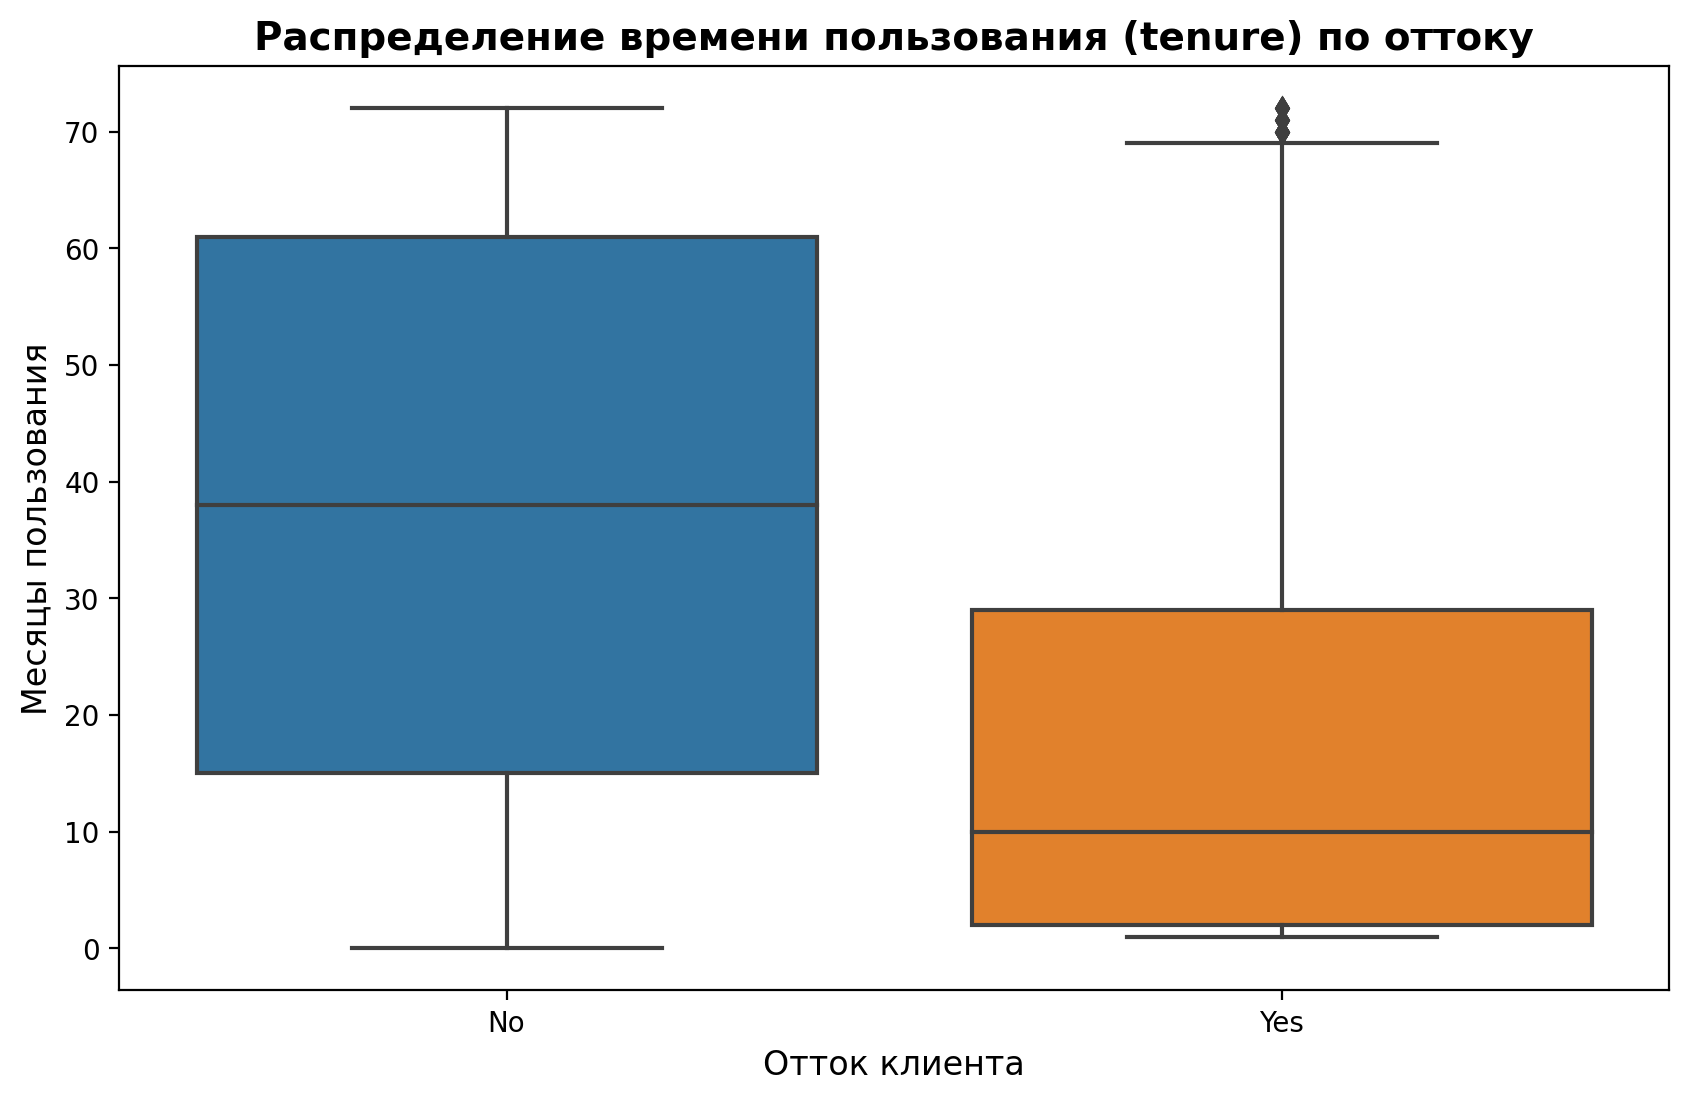

In [18]:
plt.figure(figsize=(10, 6), dpi=200)
sns.boxplot(data=churn_df, x='Churn', y='tenure')
plt.title('Распределение времени пользования (tenure) по оттоку', fontsize=14, fontweight='bold')
plt.xlabel('Отток клиента', fontsize=12)
plt.ylabel('Месяцы пользования', fontsize=12)
plt.show()

### Вывод: У уходящих клиентов значительно меньше tenure (медиана около 10 мес), а у оставшихся клиентов медиана около 40 мес)

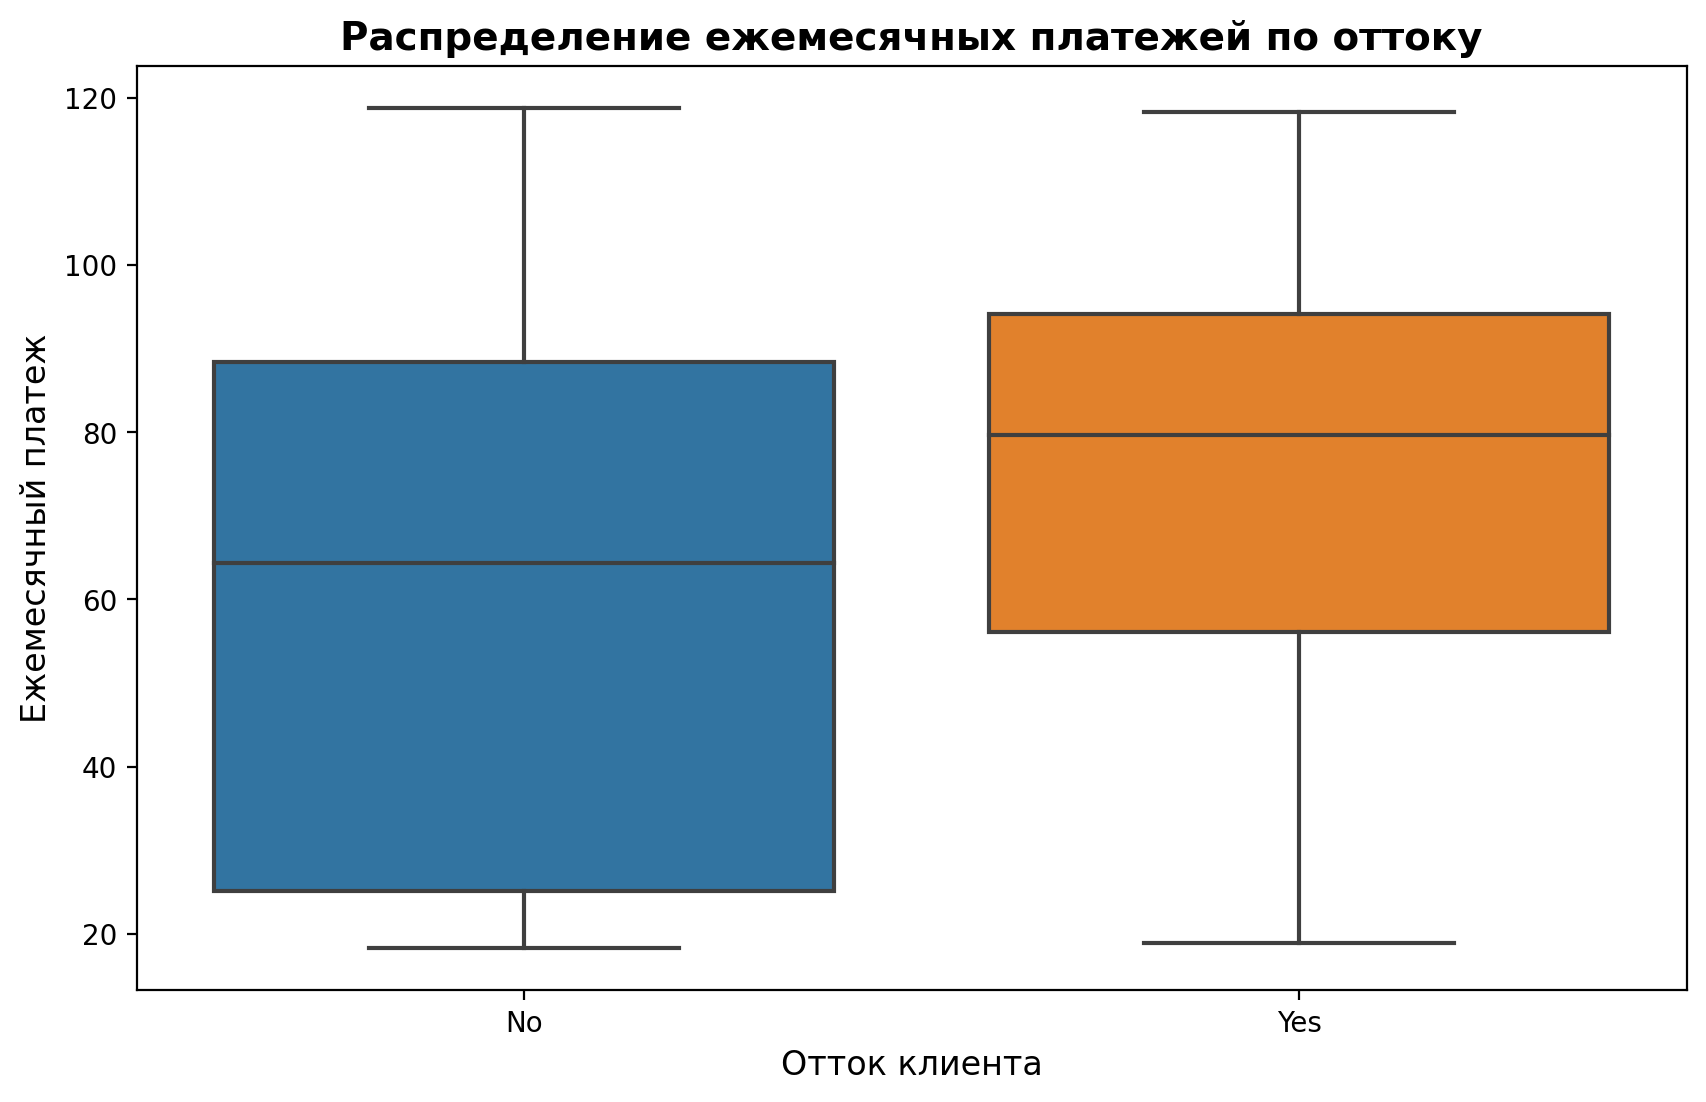

In [19]:
plt.figure(figsize=(10, 6), dpi=200)
sns.boxplot(data=churn_df, x='Churn', y='MonthlyCharges')
plt.title('Распределение ежемесячных платежей по оттоку', fontsize=14, fontweight='bold')
plt.xlabel('Отток клиента', fontsize=12)
plt.ylabel('Ежемесячный платеж', fontsize=12)
plt.show()

### Вывод: У уходящих клиентов выше MonthlyCharges (медиана около 80)

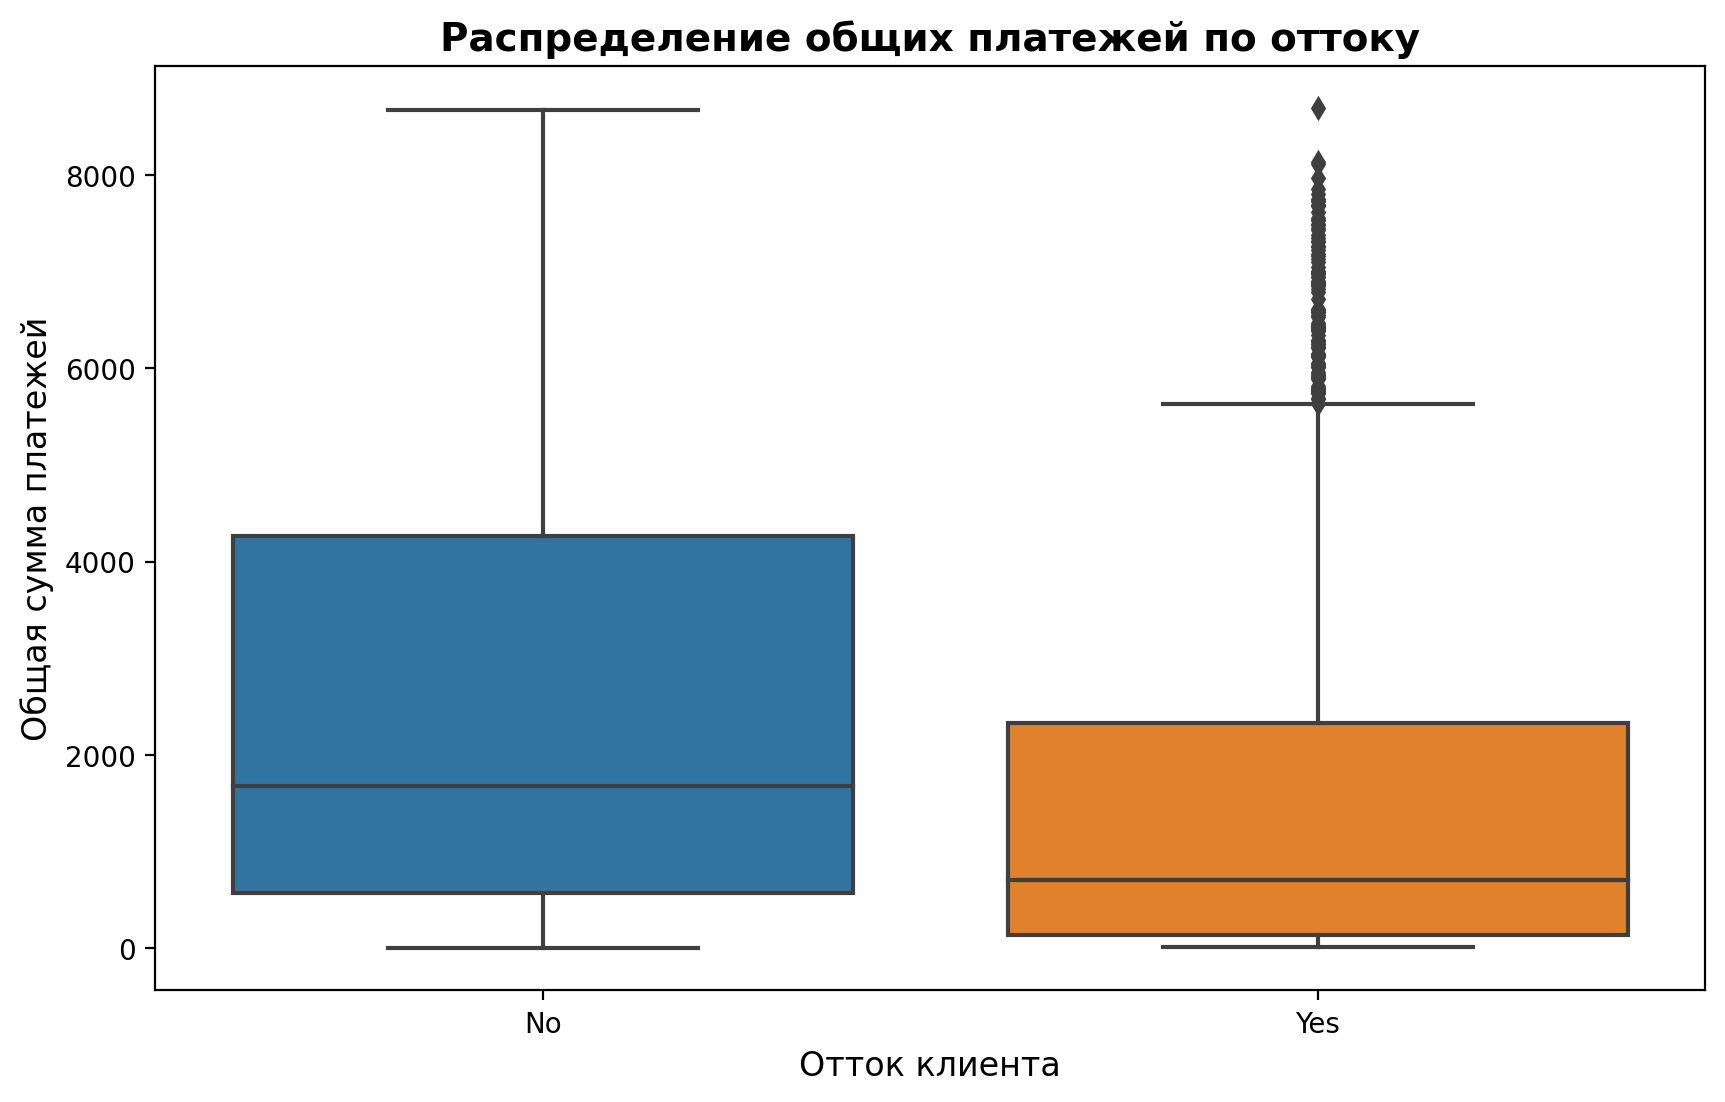

In [20]:
plt.figure(figsize=(10, 6), dpi=200)
sns.boxplot(data=churn_df, x='Churn', y='TotalCharges')
plt.title('Распределение общих платежей по оттоку', fontsize=14, fontweight='bold')
plt.xlabel('Отток клиента', fontsize=12)
plt.ylabel('Общая сумма платежей', fontsize=12)
plt.show()

### Вывод: у уходящих клиентов ниже TotalCharges, следовательно они недолго были клиентами

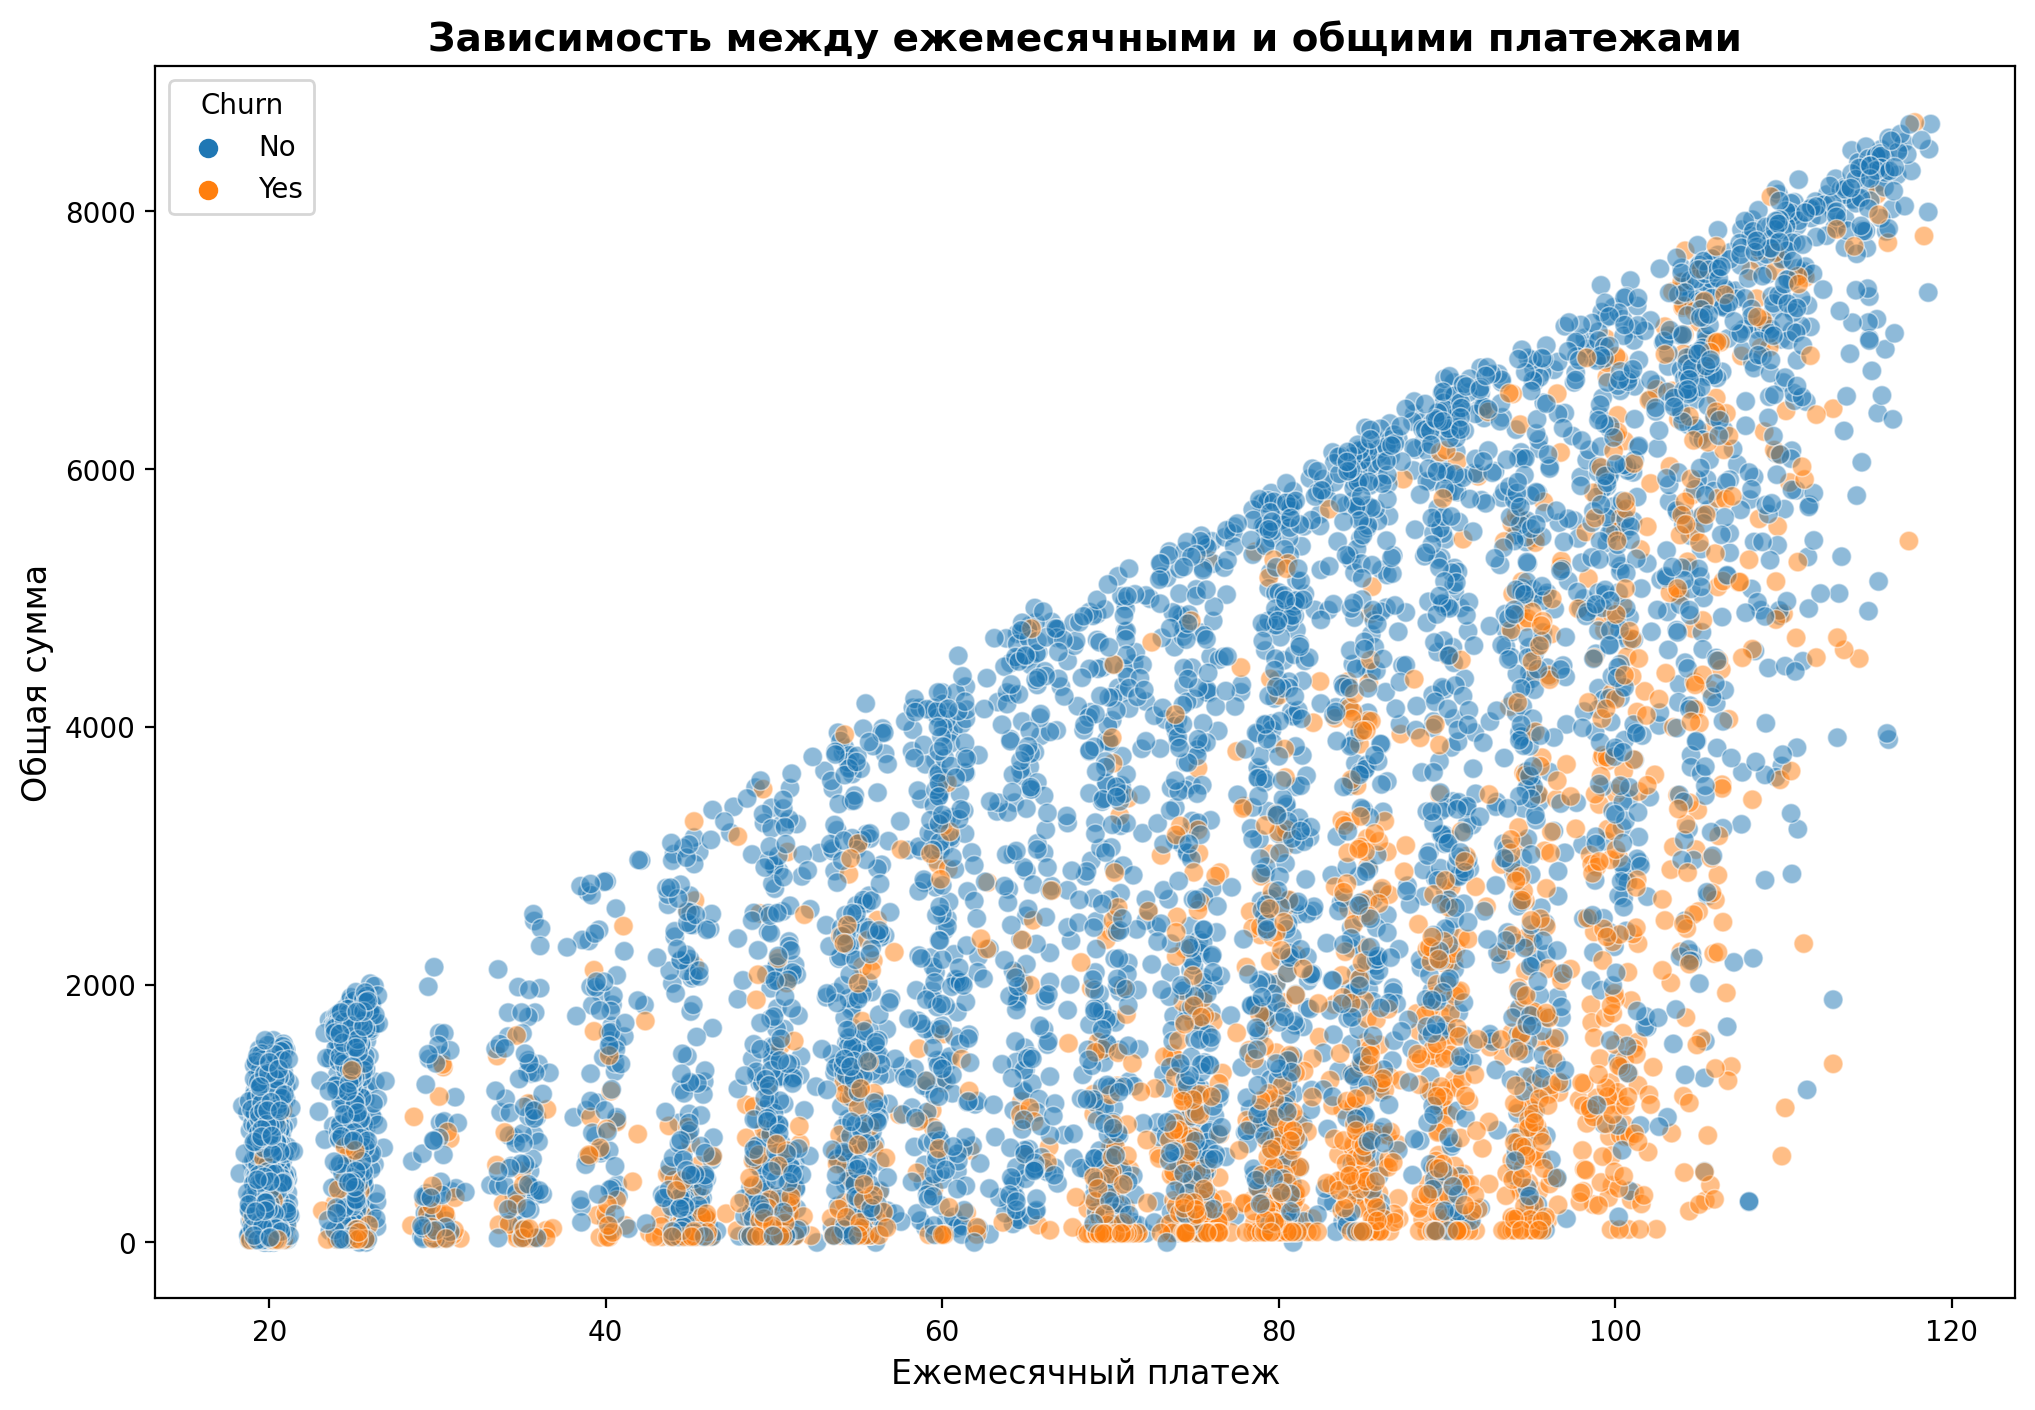

In [21]:
plt.figure(figsize=(12, 8), dpi=200)
sns.scatterplot(data=churn_df, x='MonthlyCharges', y='TotalCharges', hue='Churn', alpha=0.5, s=50)
plt.title('Зависимость между ежемесячными и общими платежами', fontsize=14, fontweight='bold')
plt.xlabel('Ежемесячный платеж', fontsize=12)
plt.ylabel('Общая сумма', fontsize=12)
plt.show()

### Вывод: Клиенты с высокими MonthlyCharges но низкими TotalCharges (новые клиенты с дорогими тарифами) часто уходят

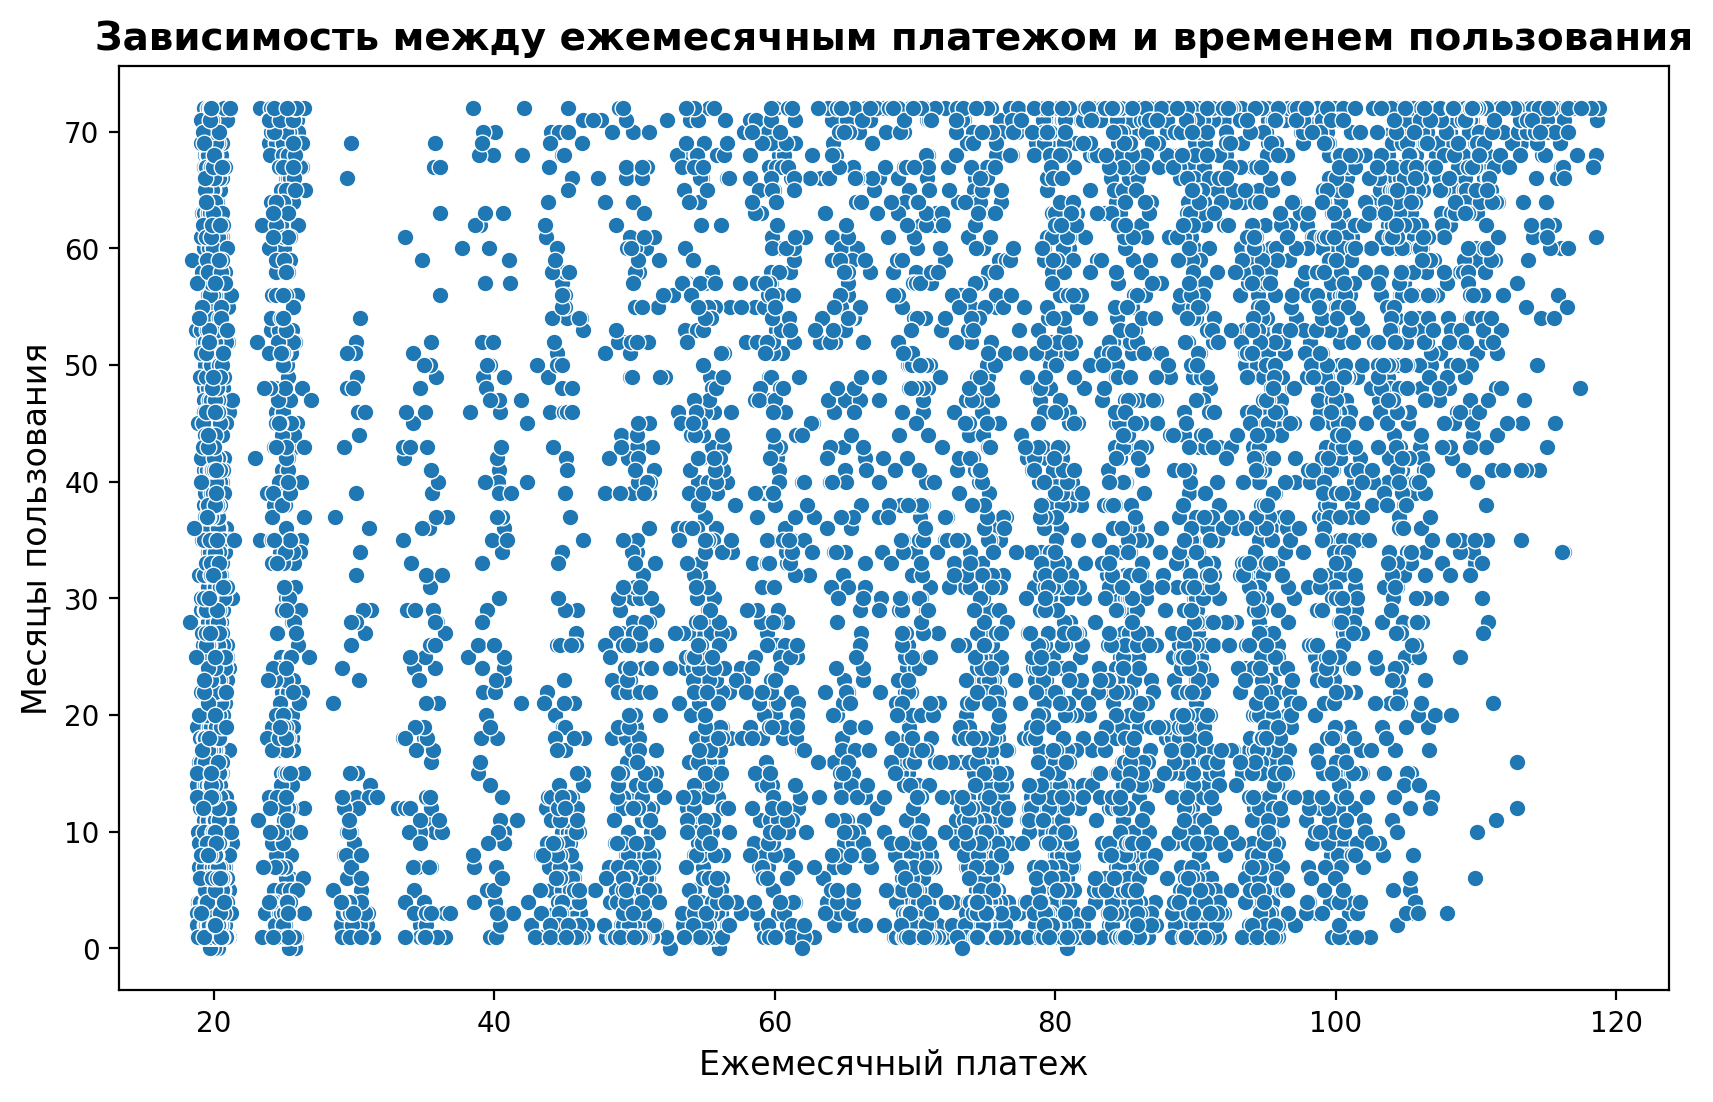

In [22]:
plt.figure(figsize=(10, 6), dpi=200)
sns.scatterplot(data=churn_df, x='MonthlyCharges', y='tenure')
plt.title('Зависимость между ежемесячным платежом и временем пользования', fontsize=14, fontweight='bold')
plt.xlabel('Ежемесячный платеж', fontsize=12)
plt.ylabel('Месяцы пользования', fontsize=12)
plt.show()

### Вывод: Нет явной линейной зависимости между MonthlyCharges и tenure

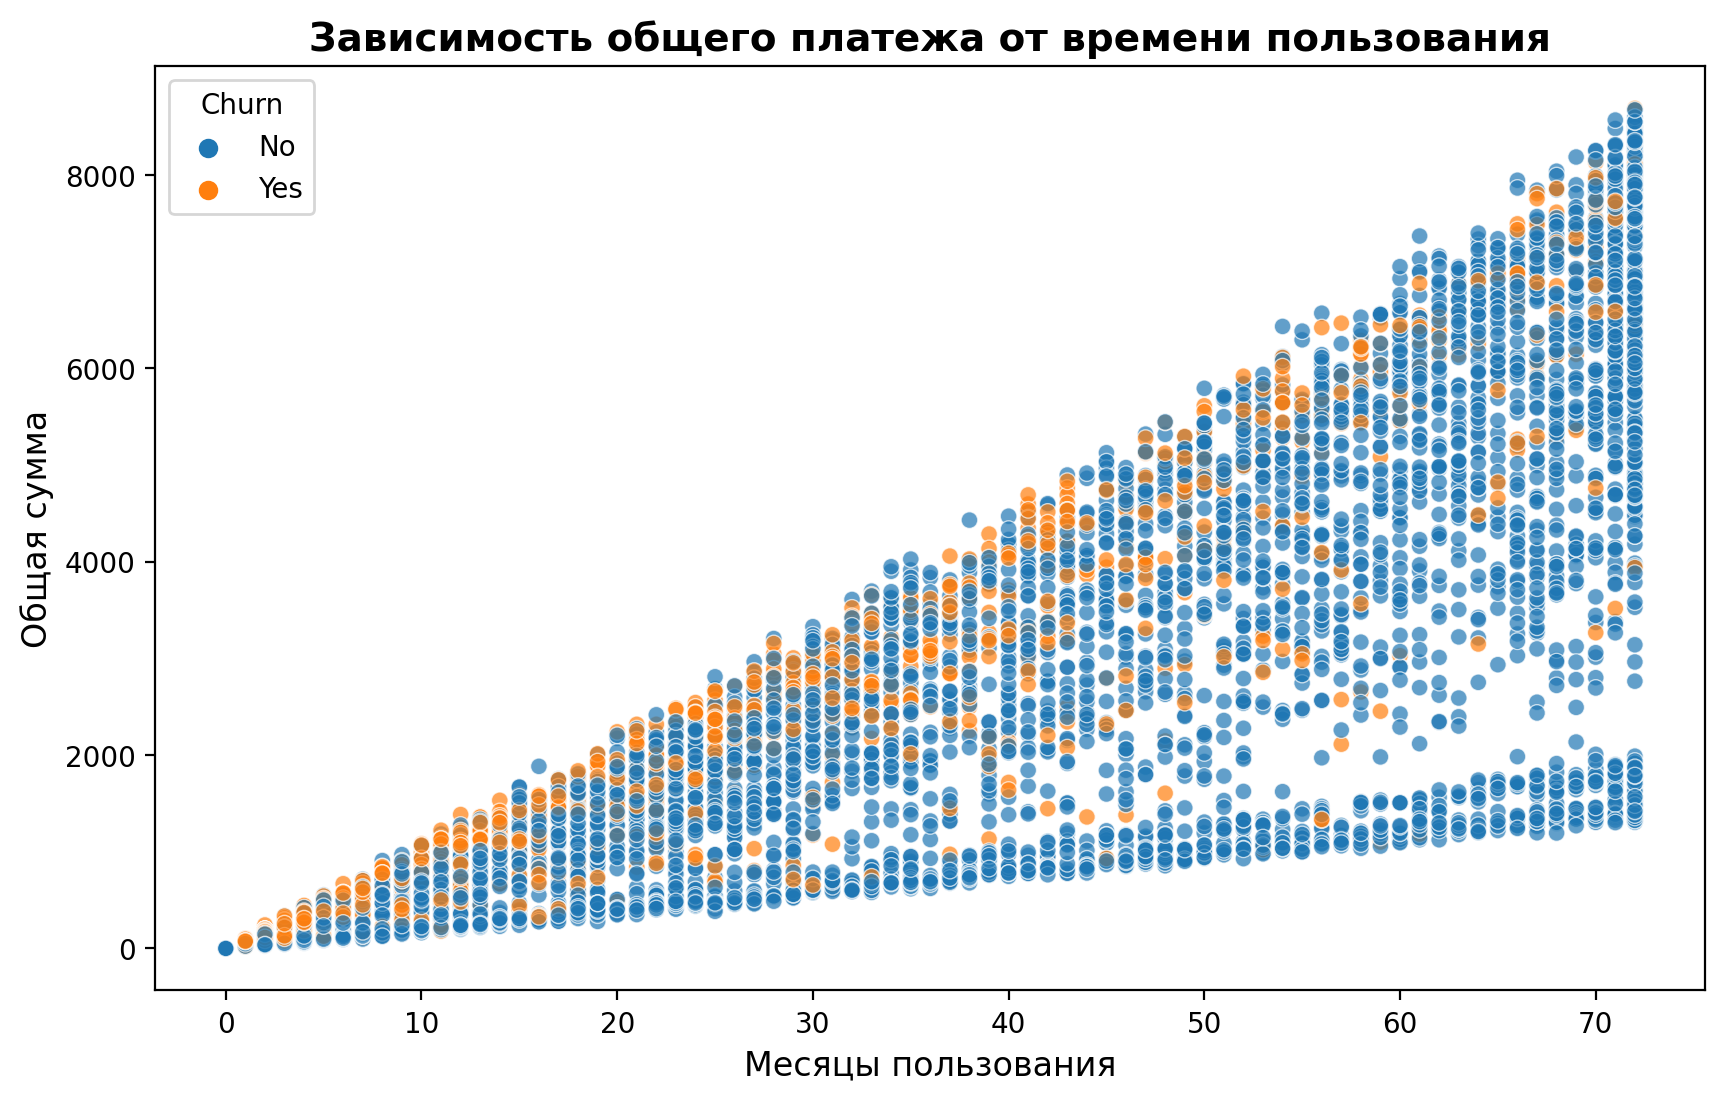

In [23]:
plt.figure(figsize=(10, 6), dpi=200)
sns.scatterplot(data=churn_df, x='tenure', y='TotalCharges', hue='Churn', alpha=0.7)
plt.title('Зависимость общего платежа от времени пользования', fontsize=14, fontweight='bold')
plt.xlabel('Месяцы пользования', fontsize=12)
plt.ylabel('Общая сумма', fontsize=12)
plt.show()

### Вывод: Клиенты с маленьким tenure и низкими TotalCharges часто уходят

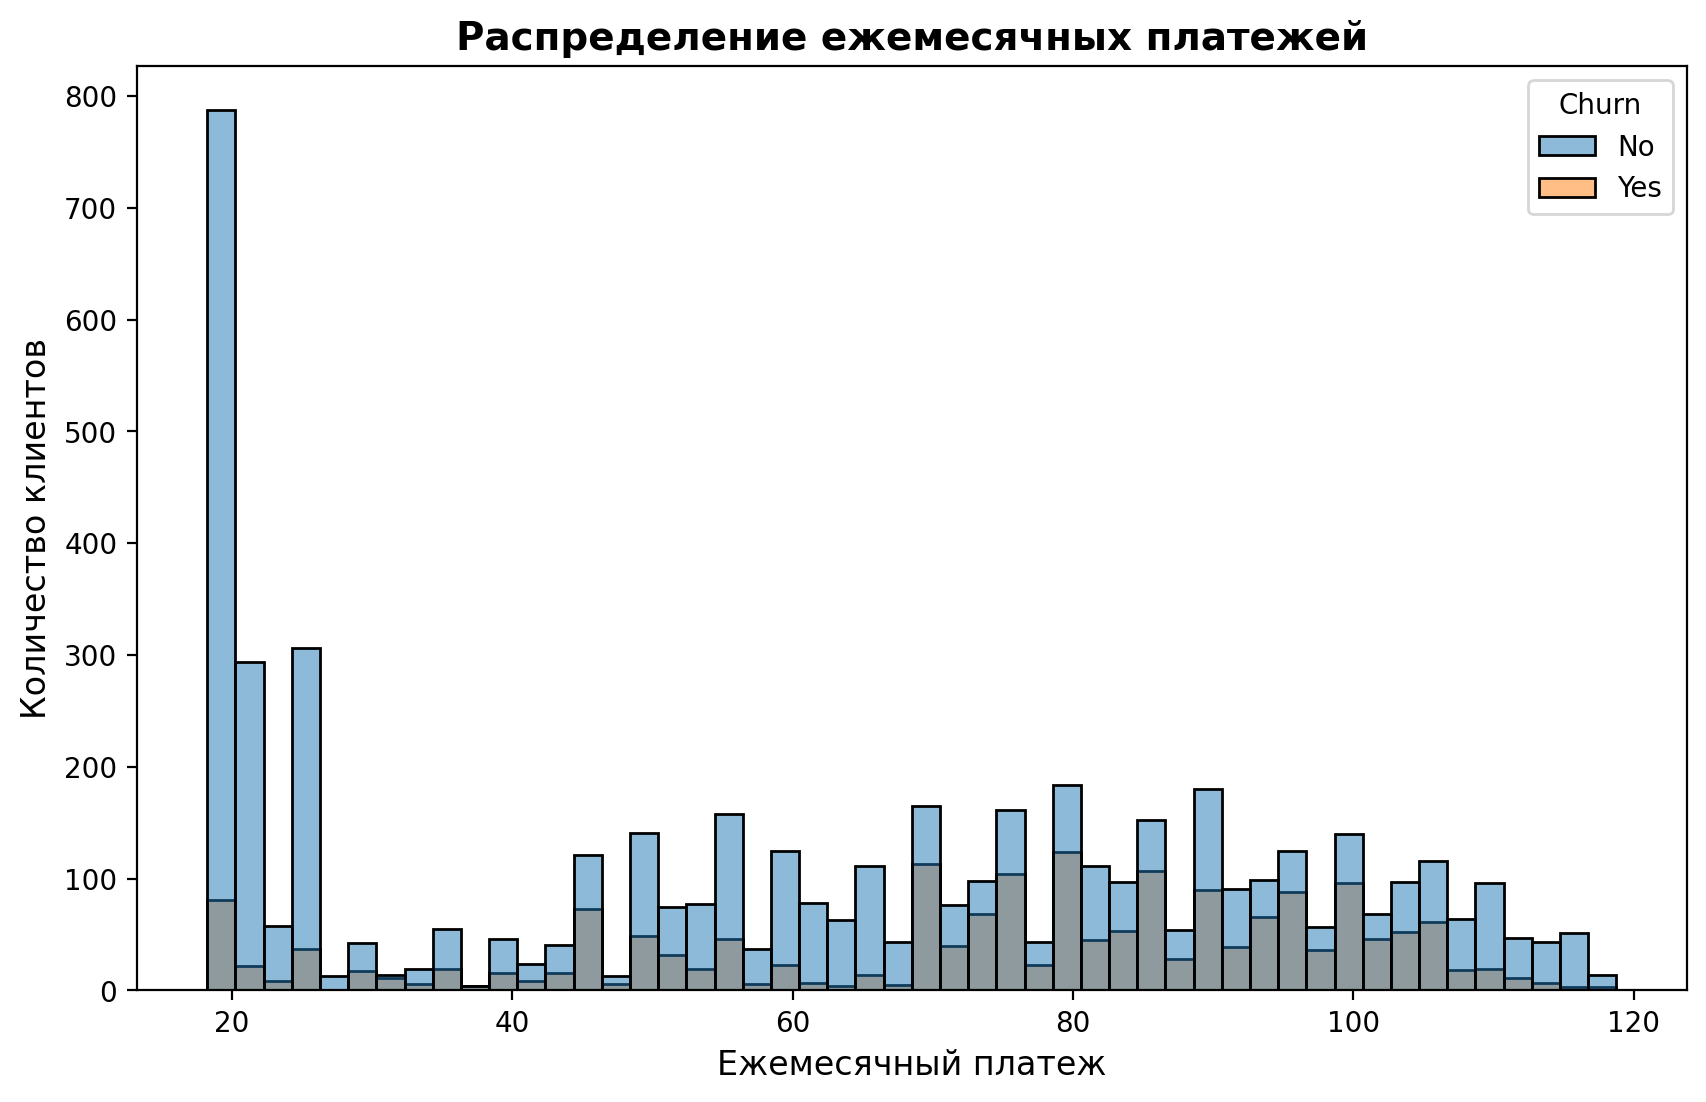

In [24]:
plt.figure(figsize=(10, 6), dpi=200)
sns.histplot(data=churn_df, x='MonthlyCharges', hue='Churn', bins=50)
plt.title('Распределение ежемесячных платежей', fontsize=14, fontweight='bold')
plt.xlabel('Ежемесячный платеж', fontsize=12)
plt.ylabel('Количество клиентов', fontsize=12)
plt.show()

### Вывод: Уходящие клиенты чаще в диапазоне 70-100

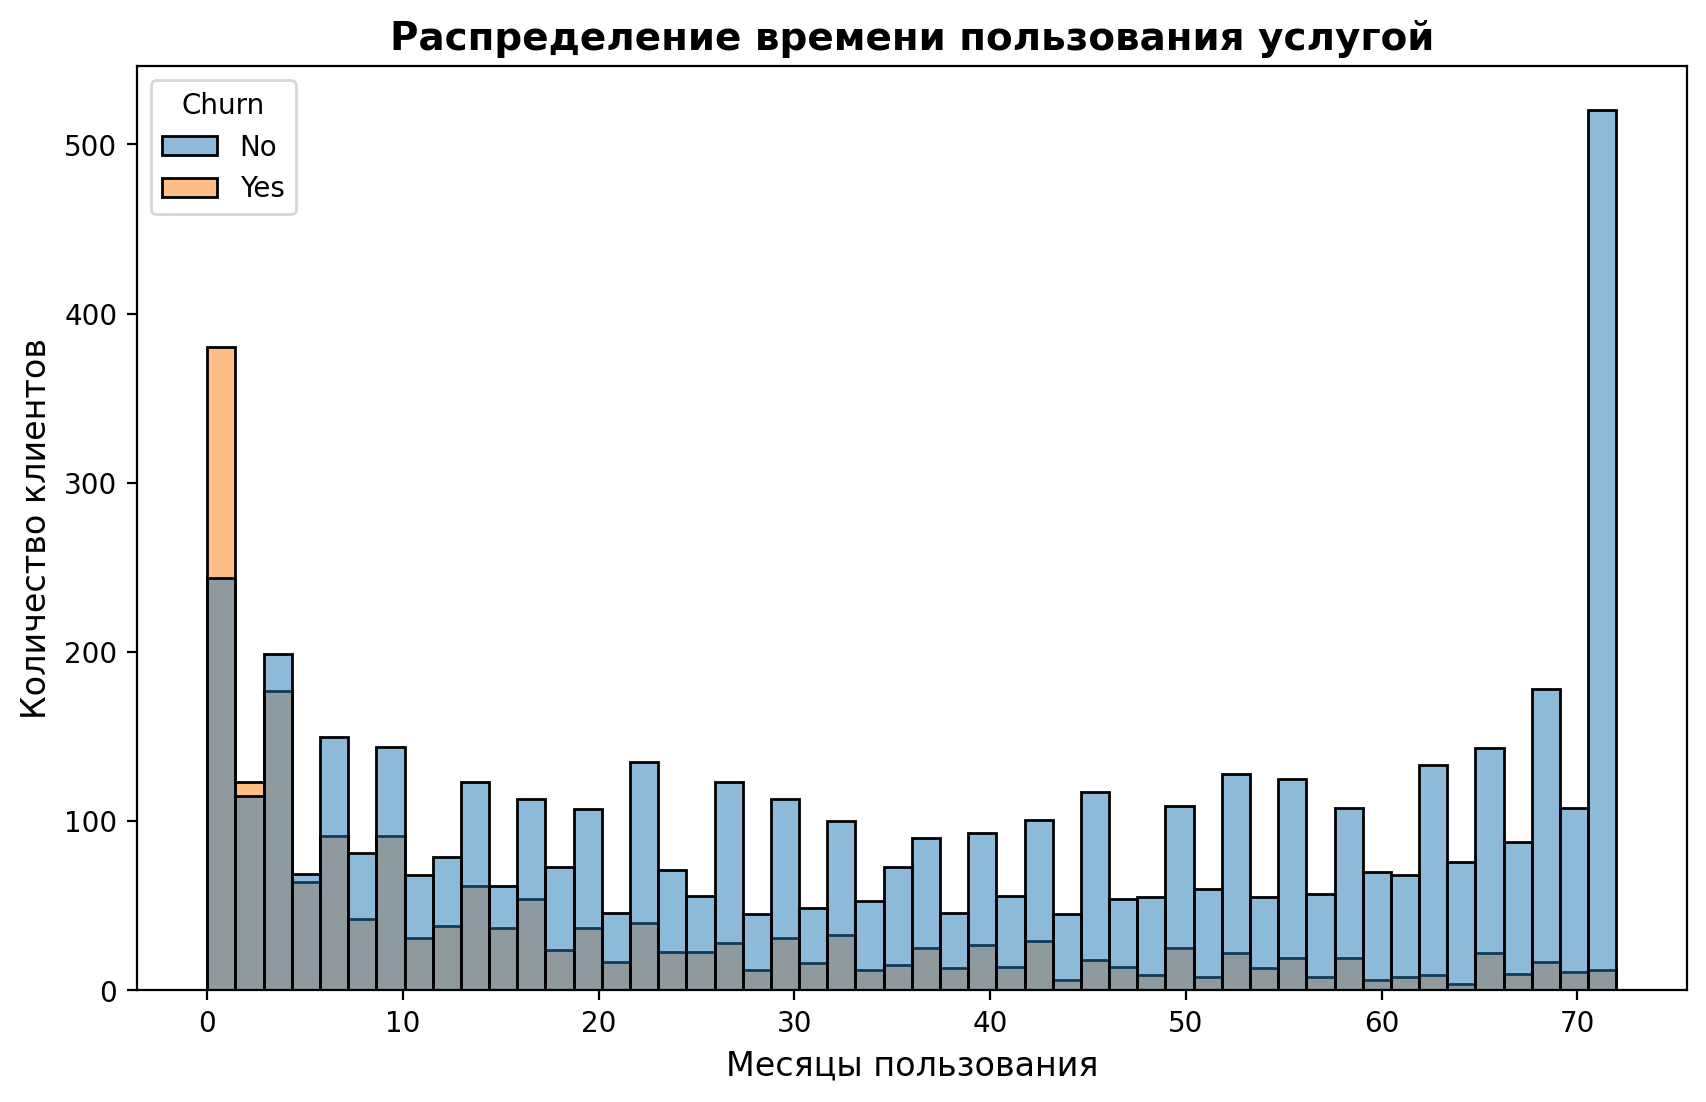

In [25]:
plt.figure(figsize=(10, 6), dpi=200)
sns.histplot(data=churn_df, x='tenure', hue='Churn', bins=50)
plt.title('Распределение времени пользования услугой', fontsize=14, fontweight='bold')
plt.xlabel('Месяцы пользования', fontsize=12)
plt.ylabel('Количество клиентов', fontsize=12)
plt.show()

### Вывод: Новые клиенты (первые 10 месяцев) чаще уходят. После 30 месяцев отток минимален

In [26]:
# Создадим числовой признак оттока где 1 это клиент покинул компанию
churn_df['Churn_num'] = churn_df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
churn_df['Churn_num']

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Churn_num, Length: 7043, dtype: int64

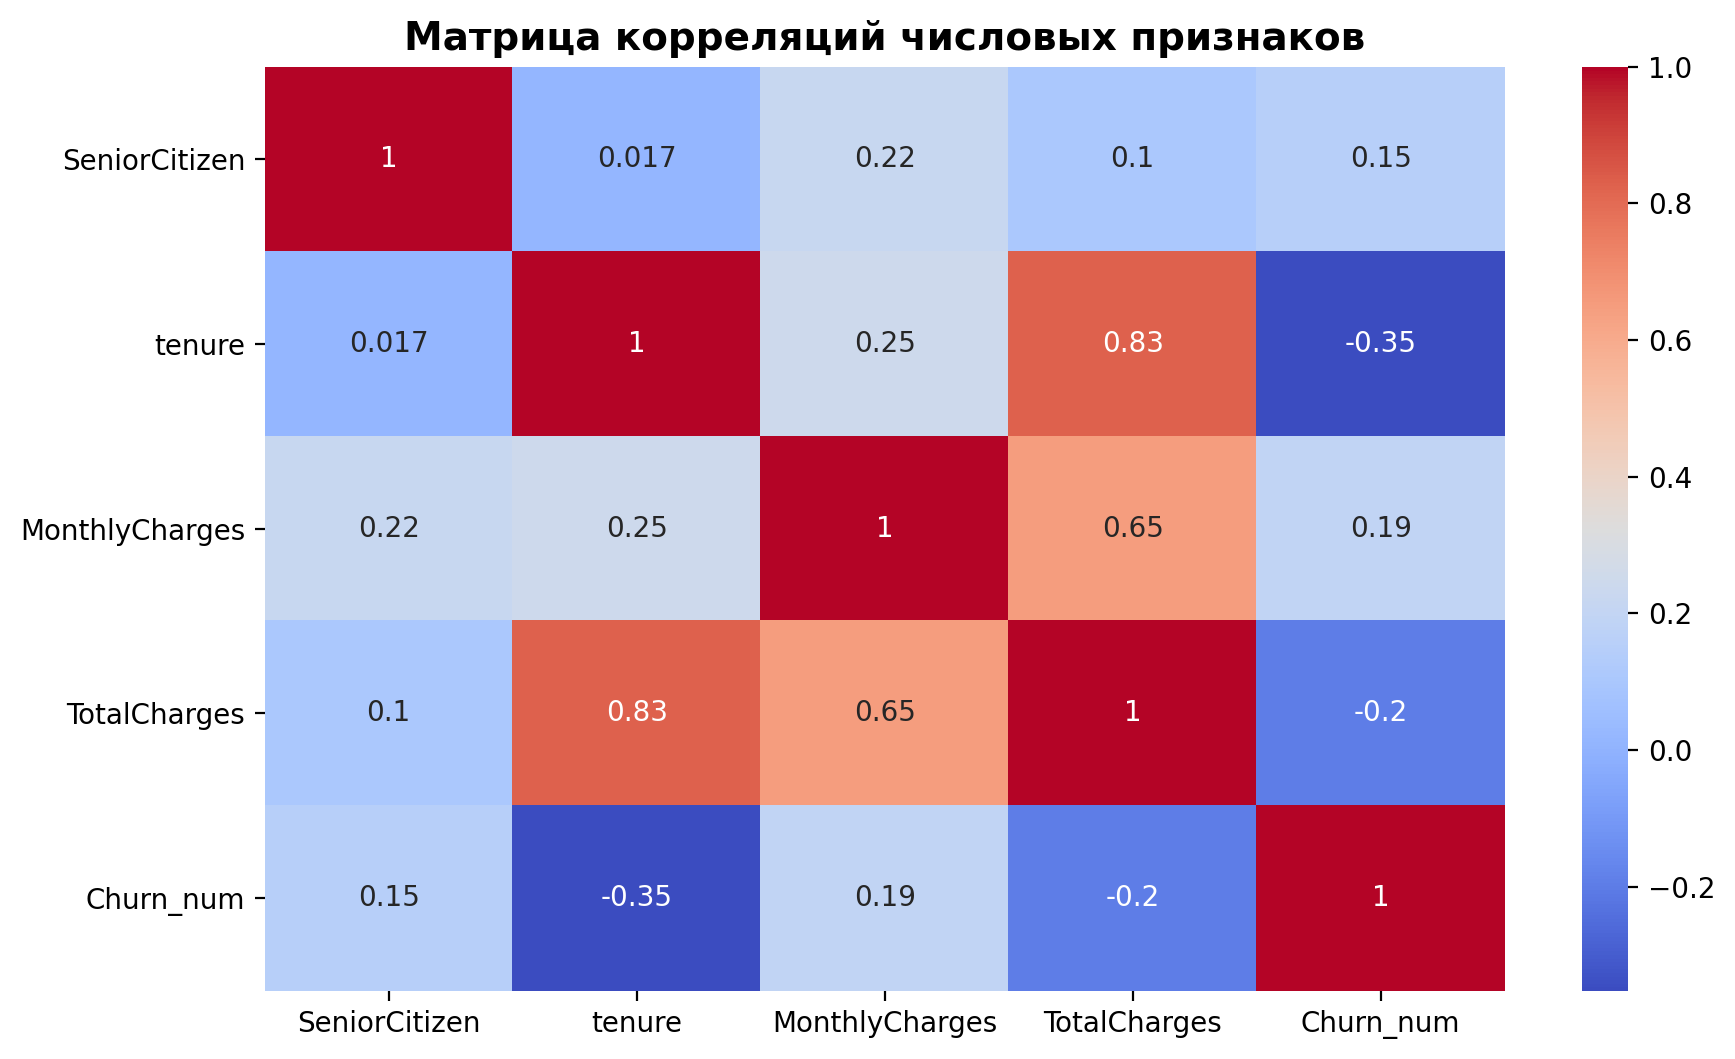

In [27]:
plt.figure(figsize=(10, 6), dpi=200)
sns.heatmap(data=churn_df.corr(), annot=True, cmap='coolwarm')
plt.title('Матрица корреляций числовых признаков', fontsize=14, fontweight='bold')
plt.show()

### Выводы: 

##### Категориальные признаки: 
1) Данные несбалансированы. Стоит обратить внимание
2) Мужчин и женщин одинаковое количество. Также нет зависимости целевой переменной от гендера 
3) Клиентов с партнером и без почти одинаковое количество. Клиенты без партнера немного чаще покидают компанию
4) Если у клиента есть иждивенцы, то он вероятнее всего не покинет компанию
5) У клиентов в 90% случаев есть телефон
6) Чаще всего интернет провайдер: Fiber optic. Далее - DSL. Реже - нет интернет провайдера. Если интернет провадер Fiber optic, то вероятность что клиент покинет компанию больше чем при интернет провайдере DSL или при отсутствии провайдера. При отсутствии провайдера очень низкая вероятность того, что клиент покинет компанию 
7) Чаще всего у клиентов нет онлайн защиты (OnlineSecurity), резервного копирования (OnlineBackup),  защиты устройств (DeviceProtection) и технической поддержки (TechSupport). Но если хотя бы одна из этих услуг подключена или у пользователя вообще нет интернета, то клиент вероятнее всего останется в компании. 
8) Клиентов со стриминговым тв такое же кол-во как и клиентов без этой функции. То же самое с клиентами с доступом к стриминговым фильмам. Клиентов с доступом и без доступа равное количество. Наличие стримингового тв и доступа к стриминговым фильмам почти не влияет на целевую переменную 
9) Больше клиентов с контрактом на месяц. Но такие клиенты гораздо чаще покидают компанию. На втором месте по количеству - клиенты с двухлетним контрактов. И они реже всего покидают компанию (почти никогда)
10) У клиентов чаще всего есть возможность получать счета на бумаге. Клиенты с такой возможностью чаще уходят из компании 
11) Наиболее часто используемый способ оплаты это Electronic check. При оплате электронным чеком клиенты гораздо чаще покидают компанию, чем при оплате остальными способами. Другие способы: Mailed check, Bank transfer (automatic), Credit card(automatic) используются с одинаковой частотой. 

##### Непрерывные признаки: 
1) Кол-во месяцев в течение которых клиент сотрудничал с компанией сильно влияет на целевую переменную. Чаще уходят клиенты у которых короткое время пользования (в основном до 20 месяцев), медиана около 10 месяцев. Клиенты, которые ОСТАЛИСЬ (Churn = No): Долгое время пользования (в основном от 30+ месяцев), медиана около 40 месяцев, много "постоянных" клиентов
2) Чаще уходят клиенты с более высоким MonthlyCharges (ежемесячным платежом). В основном он от 60. Медиана = 80 
3) ?? С общей суммой оплаты непонятно. Непонятно как она влияет на целевую переменную. Много выбросов в боксплоте
4) Чаще всего MonthlyCharges около 20. А больший отток клиентов происходит когда ежемесячная сумма в диапазоне от 70 до 110
5) На дисплоте общей суммы видим большое кол-во клиентов которые ушли из компании, но у них низкий TotalCharges . Скорее всего эти клиенты просто пробыли в компании маленькое кол-во месяцев и ушли (под вопросом)
6) Чем больше месяцев клиент в компании - тем больше вероятность что он не уйдет в отток. В отток чаще всего уходят пользователи которые сотрудничали с компанией до 5-10 месяцев

### 2.5 Глубокий анализ через сводные таблицы

In [28]:
pd.pivot_table(churn_df, index=['gender', 'Partner'], values='Churn_num', aggfunc=['count', 'mean']) 
# Выяснили что наличие партнера влияет на отток 

count      mean
               Churn_num Churn_num
gender Partner                    
Female No           1800  0.344444
       Yes          1688  0.188981
Male   No           1841  0.315046
       Yes          1714  0.204201

In [29]:
pd.pivot_table(churn_df, index=['gender', 'SeniorCitizen'], values='Churn_num', aggfunc=['count', 'mean'])
# У пожилых клиентов высокий процент ухода в отток 

count      mean
                     Churn_num Churn_num
gender SeniorCitizen                    
Female 0                  2920  0.239384
       1                   568  0.422535
Male   0                  2981  0.232808
       1                   574  0.411150

In [30]:
pd.pivot_table(churn_df, index=['SeniorCitizen', 'Partner', 'Dependents'], values='Churn_num', aggfunc=['count', 'mean'])
# Пожилой человек без партнера более склонен уйти в отток SeniorCitizen

count      mean
                                 Churn_num Churn_num
SeniorCitizen Partner Dependents                    
0             No      No              2719  0.311512
                      Yes              353  0.212465
              Yes     No              1163  0.208083
                      Yes             1666  0.137455
1             No      No               561  0.491979
                      Yes                8  0.250000
              Yes     No               490  0.363265
                      Yes               83  0.240964

In [31]:
pd.pivot_table(churn_df, index=['Dependents', 'gender'], values='Churn_num', aggfunc=['count', 'mean'])
# Вне зависимости от пола если есть иждивенцы, то меньше вероятность оттока

count      mean
                  Churn_num Churn_num
Dependents gender                    
No         Female      2460  0.314634
           Male        2473  0.310958
Yes        Female      1028  0.160506
           Male        1082  0.148799

In [32]:
pd.pivot_table(churn_df, index=['Dependents', 'Partner'], values='Churn_num', aggfunc=['count', 'mean'])
# Клиенты без партнёра и иждивенцев - группа повышенного риска оттока 

count      mean
                   Churn_num Churn_num
Dependents Partner                    
No         No           3280  0.342378
           Yes          1653  0.254083
Yes        No            361  0.213296
           Yes          1749  0.142367

In [33]:
pd.pivot_table(churn_df, index=['PhoneService', 'SeniorCitizen'], values='Churn_num', aggfunc=['count', 'mean'])
# Достаточно мало пожилых без телефона. Но почти половина из них ушли в отток 

count      mean
                           Churn_num Churn_num
PhoneService SeniorCitizen                    
No           0                   578  0.217993
             1                   104  0.423077
Yes          0                  5323  0.238024
             1                  1038  0.416185

In [34]:
pd.pivot_table(churn_df, index=['PhoneService', 'InternetService'], values='Churn_num', aggfunc=['count', 'mean'])
# Большой процент оттока среди пользователей у которых интернет провайдер Fiber optic

count      mean
                             Churn_num Churn_num
PhoneService InternetService                    
No           DSL                   682  0.249267
Yes          DSL                  1739  0.166187
             Fiber optic          3096  0.418928
             No                   1526  0.074050

In [35]:
pd.pivot_table(churn_df, index=['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport'], values='Churn_num', aggfunc=['count', 'mean'])
# Самая высокая вероятность уйти в отток: интернет провайдер Fiber optic и все перечисленные услуги не подключены 
# Самая низкая: все услуги подключены, либо интернета вообще нет 

count  \
                                                                                                Churn_num   
InternetService OnlineSecurity      OnlineBackup        DeviceProtection    TechSupport                     
DSL             No                  No                  No                  No                        419   
                                                                            Yes                       132   
                                                        Yes                 No                        130   
                                                                            Yes                       111   
                                    Yes                 No                  No                        156   
                                                                            Yes                       105   
                                                        Yes                 No                         83   
                                                                            Yes                       105   
                Yes                 No                  No                  No                        160   
                                                                            Yes                       127   
                                                        Yes                 No                         88   
                                                                            Yes                       168   
                                    Yes                 No                  No                        106   
                                                                            Yes                       151   
                                                        Yes                 No                        101   
                                                                            Yes                       279   
Fiber optic     No                  No                  No                  No                        848   
                                                                            Yes                       110   
                                                        Yes                 No                        316   
                                                                            Yes                       129   
                                    Yes                 No                  No                        315   
                                                                            Yes                       102   
                                                        Yes                 No                        286   
                                                                            Yes                       151   
                Yes                 No                  No                  No                        148   
                                                                            Yes                        40   
                                                        Yes                 No                         87   
                                                                            Yes                        75   
                                    Yes                 No                  No                        108   
                                                                            Yes                        68   
                                                        Yes                 No                        122   
                                                                            Yes                       191   
No              No internet service No internet service No internet service No internet service      1526   

                                                                                                     mean  
                                                                   

In [36]:
pd.pivot_table(churn_df, index=['InternetService', 'StreamingTV', 'StreamingMovies'], values='Churn_num', aggfunc=['count', 'mean'])
# Самая низкая вероятность оттока: InternetService = DSL и оба стрминговых сервиса подключены. Либо интернета вообще нет 

count      mean
                                                        Churn_num Churn_num
InternetService StreamingTV         StreamingMovies                        
DSL             No                  No                       1113  0.245283
                                    Yes                       351  0.168091
                Yes                 No                        327  0.149847
                                    Yes                       630  0.123810
Fiber optic     No                  No                        905  0.466298
                                    Yes                       441  0.426304
                Yes                 No                        440  0.440909
                                    Yes                      1310  0.376336
No              No internet service No internet service      1526  0.074050

In [37]:
pd.pivot_table(churn_df, index='Contract', values='Churn_num', aggfunc=['count', 'mean'])
# Клиенты с контрактом на месяц гораздо чаще покидают компанию. С контрактом на 2 года - покидают ОЧЕНЬ редко

count      mean
               Churn_num Churn_num
Contract                          
Month-to-month      3875  0.427097
One year            1473  0.112695
Two year            1695  0.028319

In [38]:
pd.pivot_table(churn_df, index=['tenure', 'Contract'], values='Churn_num', aggfunc=['count', 'mean'])
# Вся таблица конечно не отобразится, но большой процент клиентов берет контракт 'Month-to-month' и по его завершению покидают компанию 

count      mean
                      Churn_num Churn_num
tenure Contract                          
0      One year               1  0.000000
       Two year              10  0.000000
1      Month-to-month       604  0.629139
       One year               7  0.000000
       Two year               2  0.000000
...                         ...       ...
71     One year              28  0.000000
       Two year             137  0.036496
72     Month-to-month         2  0.000000
       One year              17  0.117647
       Two year             343  0.011662

[218 rows x 2 columns]

In [39]:
pd.pivot_table(churn_df, index='PaperlessBilling', values='Churn_num', aggfunc=['count', 'mean'])
# Клиенты без возможности получать счета на бумаге уходят реже

count      mean
                 Churn_num Churn_num
PaperlessBilling                    
No                    2872  0.163301
Yes                   4171  0.335651

In [40]:
pd.pivot_table(churn_df, index='PaymentMethod', values='Churn_num', aggfunc=['count', 'mean'])
# Клиенты со способом оплаты Electronic check чаще уходят в отток 

count      mean
                          Churn_num Churn_num
PaymentMethod                                
Bank transfer (automatic)      1544  0.167098
Credit card (automatic)        1522  0.152431
Electronic check               2365  0.452854
Mailed check                   1612  0.191067

In [41]:
pd.pivot_table(churn_df, index='Churn', values=['MonthlyCharges', 'TotalCharges'], aggfunc=['min', 'max', 'mean', 'median']).T

Churn                           No          Yes
min    MonthlyCharges    18.250000    18.850000
       TotalCharges       0.000000    18.850000
max    MonthlyCharges   118.750000   118.350000
       TotalCharges    8672.450000  8684.800000
mean   MonthlyCharges    61.265124    74.441332
       TotalCharges    2549.911442  1531.796094
median MonthlyCharges    64.425000    79.650000
       TotalCharges    1679.525000   703.550000

In [42]:
# Посмотрим связаны ли суммы взимаемые с клиента с разными услугами 
pd.pivot_table(churn_df, 
               index=['Churn', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport'], 
               values=['MonthlyCharges', 'TotalCharges'], 
               aggfunc=['mean', 'median'])
# Суммы, взимаемые с клиента связаны с разными услугами. Чем больше усуг подключено - тем больше месячный платеж и общая сумма

mean  \
                                                                                      MonthlyCharges   
Churn OnlineSecurity      OnlineBackup        DeviceProtection    TechSupport                          
No    No                  No                  No                  No                       63.869945   
                                                                  Yes                      67.332934   
                                              Yes                 No                       78.037238   
                                                                  Yes                      77.775683   
                          Yes                 No                  No                       71.559636   
                                                                  Yes                      77.661677   
                                              Yes                 No                       86.899792   
                                                                  Yes                      89.005530   
      No internet service No internet service No internet service No internet service      21.136058   
      Yes                 No                  No                  No                       65.690278   
                                                                  Yes                      64.723759   
                                              Yes                 No                       75.075874   
                                                                  Yes                      78.463825   
                          Yes                 No                  No                       74.903488   
                                                                  Yes                      74.121066   
                                              Yes                 No                       84.305959   
                                                                  Yes                      90.505506   
Yes   No                  No                  No                  No                       70.760515   
                                                                  Yes                      73.402667   
                                              Yes                 No                       81.299275   
                                                                  Yes                      89.439474   
                          Yes                 No                  No                       78.880102   
                                                                  Yes                      79.283750   
                                              Yes                 No                       93.465504   
                                                                  Yes                      98.348718   
      No internet service No internet service No internet service No internet service      20.368142   
      Yes                 No                  No                  No                       72.505435   
                                                                  Yes                      72.290385   
                                              Yes                 No                       88.548437   
                                                                  Yes                      86.615385   
                          Yes                 No                  No                       79.479762   
                                                                  Yes                      87.315909   
                                              Yes                 No                       90.501667   
                                                                  Yes                      98.270000   

                                                                                                    \
                                                                                      TotalCharges   
Churn OnlineSecurity      OnlineBackup     

In [43]:
pd.pivot_table(churn_df, index=['StreamingTV', 'StreamingMovies'], values='Churn_num', aggfunc=['count', 'mean'])
# Наличие стримингового тв и стриминговых фильмов не особо влияет на отток 

count      mean
                                        Churn_num Churn_num
StreamingTV         StreamingMovies                        
No                  No                       2018  0.344400
                    Yes                       792  0.311869
No internet service No internet service      1526  0.074050
Yes                 No                        767  0.316819
                    Yes                      1940  0.294330

In [44]:
pd.pivot_table(churn_df, 
               index=['InternetService'], 
               values=['MonthlyCharges', 'TotalCharges'], 
               aggfunc=['mean', 'median']).T
# Цены сильно зависят от интернет провайдера. У Fiber optic	цена выше , чем у DSL

InternetService                DSL  Fiber optic          No
mean   MonthlyCharges    58.102169    91.500129   21.079194
       TotalCharges    2115.411338  3205.304570  662.604784
median MonthlyCharges    56.150000    91.675000   20.150000
       TotalCharges    1596.600000  2660.650000  519.200000

In [45]:
# Проверим гипотезу: чаще всего уходят клиенты у которых ежемесячная взимаемая сумма в диапазоне от 70 до 110
# Создадим новый признак 
churn_df['MonthlyCharges_Groups'] = pd.cut(churn_df['MonthlyCharges'], bins=4)
churn_df['MonthlyCharges_Groups'].unique()

[(18.15, 43.375], (43.375, 68.5], (68.5, 93.625], (93.625, 118.75]]
Categories (4, interval[float64]): [(18.15, 43.375] < (43.375, 68.5] < (68.5, 93.625] < (93.625, 118.75]]

In [46]:
pd.pivot_table(churn_df, index='MonthlyCharges_Groups', values='Churn_num', aggfunc=['count', 'mean'])
# Не сильная зависимость. Но немного чаще уходят клиенты у которых ежемесячный взнос от 70 до 95 

count      mean
                      Churn_num Churn_num
MonthlyCharges_Groups                    
(18.15, 43.375]            1899  0.123223
(43.375, 68.5]             1377  0.214960
(68.5, 93.625]             2290  0.368122
(93.625, 118.75]           1477  0.335816

In [47]:
# Попробуем сделать то же самое с общей суммой
churn_df['TotalCharges_Groups'] = pd.cut(churn_df['TotalCharges'], bins=10)
churn_df['TotalCharges_Groups'].unique()

[(-8.685, 868.48], (1736.96, 2605.44], (2605.44, 3473.92], (3473.92, 4342.4], (5210.88, 6079.36], (4342.4, 5210.88], (7816.32, 8684.8], (868.48, 1736.96], (6947.84, 7816.32], (6079.36, 6947.84]]
Categories (10, interval[float64]): [(-8.685, 868.48] < (868.48, 1736.96] < (1736.96, 2605.44] < (2605.44, 3473.92] ... (5210.88, 6079.36] < (6079.36, 6947.84] < (6947.84, 7816.32] < (7816.32, 8684.8]]

In [48]:
pd.pivot_table(churn_df, index='TotalCharges_Groups', values='Churn_num', aggfunc=['count', 'mean'])
# Не сильная зависимость. Но чаще уходят клиенты у которых общая сумма от 10 до 885
# Скорее всего брали на короткий срок и потом уходили. Поэтому общая сумма минимальна

count      mean
                    Churn_num Churn_num
TotalCharges_Groups                    
(-8.685, 868.48]         2701  0.376897
(868.48, 1736.96]        1227  0.221679
(1736.96, 2605.44]        685  0.249635
(2605.44, 3473.92]        503  0.240557
(3473.92, 4342.4]         460  0.160870
(4342.4, 5210.88]         414  0.173913
(5210.88, 6079.36]        396  0.146465
(6079.36, 6947.84]        311  0.147910
(6947.84, 7816.32]        224  0.142857
(7816.32, 8684.8]         122  0.040984

In [49]:
# Теперь удалим признаки MonthlyCharges_Groups и TotalCharges_Groups тк они нужны были временно. Для модели они излишни 
churn_df = churn_df.drop(['MonthlyCharges_Groups', 'TotalCharges_Groups'], axis=1)

## 3. Создание новых признаков (Feature Engineering)

In [50]:
# Группировка кол-ва месяцев в течение которых пользователь сотрудничал с компанией
churn_df['tenure_group'] = pd.cut(churn_df['tenure'],
                bins=[-1, 1, 6, 12, 24, 36, 48, 60, 72], 
                labels=['new', '1-6m', '6-12m', '1-2y', '2-3y', '3-4y', '4-5y', '5-6y'])

In [51]:
# Количество подключенных услуг 
service_columns = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                   'TechSupport', 'StreamingTV', 'StreamingMovies']
churn_df['num_services'] = churn_df[service_columns].apply(lambda x: (x == 'Yes').sum(), axis=1)

In [52]:
# Клиенты у которых подключены услуги OnlineSecurity, OnlineBackup,	DeviceProtection, TechSupport
churn_df['all_internet_services'] = ((churn_df['OnlineSecurity'] == 'Yes') & 
                                     (churn_df['OnlineBackup'] == 'Yes') & 
                                     (churn_df['DeviceProtection'] == 'Yes') & 
                                     (churn_df['TechSupport'] == 'Yes')
                                    ).astype(int)

In [53]:
# Клиенты без иждивенцев и партнера
churn_df['IsAlone'] = ((churn_df['Dependents'] == 'No') & 
                       (churn_df['Partner'] == 'No')).astype(int) 

In [54]:
# Одинокий пожилой клиент 
churn_df['senior_alone'] = ((churn_df['SeniorCitizen'] == 1) &
                            (churn_df['IsAlone'] == 1)).astype(int)

In [55]:
# Создадим еще признак fiber_without_services - клиент у которого интернет провайдер Fiber optic и не подключена ни одна услуга - высокий шанс оттока 
churn_df['fiber_without_services'] = ((churn_df['InternetService'] == 'Fiber optic') & 
                        (churn_df['all_internet_services'] == 0)).astype(int)

In [56]:
# Признак "временный клиент" - короткий tenure + помесячный контракт
churn_df['temporary_customer'] = ((churn_df['tenure'] < 12) & 
                                  (churn_df['Contract'] == 'Month-to-month')).astype(int)

In [57]:
# Признак "дорогой месячный платеж"
churn_df['high_monthly_charge'] = ((churn_df['MonthlyCharges'] > 70) & 
                                   (churn_df['MonthlyCharges'] < 110)).astype(int)

In [58]:
churn_df

customerID  gender  SeniorCitizen Partner Dependents  tenure  \
0     7590-VHVEG  Female              0     Yes         No       1   
1     5575-GNVDE    Male              0      No         No      34   
2     3668-QPYBK    Male              0      No         No       2   
3     7795-CFOCW    Male              0      No         No      45   
4     9237-HQITU  Female              0      No         No       2   
...          ...     ...            ...     ...        ...     ...   
7038  6840-RESVB    Male              0     Yes        Yes      24   
7039  2234-XADUH  Female              0     Yes        Yes      72   
7040  4801-JZAZL  Female              0     Yes        Yes      11   
7041  8361-LTMKD    Male              1     Yes         No       4   
7042  3186-AJIEK    Male              0      No         No      66   

     PhoneService     MultipleLines InternetService OnlineSecurity  ... Churn  \
0              No  No phone service             DSL             No  ...    No   
1             Yes                No             DSL            Yes  ...    No   
2             Yes                No             DSL            Yes  ...   Yes   
3              No  No phone service             DSL            Yes  ...    No   
4             Yes                No     Fiber optic             No  ...   Yes   
...           ...               ...             ...            ...  ...   ...   
7038          Yes               Yes             DSL            Yes  ...    No   
7039          Yes               Yes     Fiber optic             No  ...    No   
7040           No  No phone service             DSL            Yes  ...    No   
7041          Yes               Yes     Fiber optic             No  ...   Yes   
7042          Yes                No     Fiber optic            Yes  ...    No   

     Churn_num tenure_group num_services all_internet_services IsAlone  \
0            0          new            1                     0       0   
1            0         2-3y            2                     0       1   
2            1         1-6m            2                     0       1   
3            0         3-4y            3                     0       1   
4            1         1-6m            0                     0       1   
...        ...          ...          ...                   ...     ...   
7038         0         1-2y            5                     0       0   
7039         0         5-6y            4                     0       0   
7040         0        6-12m            1                     0       0   
7041         1         1-6m            0                     0       0   
7042         0         5-6y            5                     0       1   

     senior_alone fiber_without_services  temporary_customer  \
0               0                      0                   1   
1               0                      0                   0   
2               0                      0                   1   
3               0                      0                   0   
4               0                      1                   1   
...           ...                    ...                 ...   
7038            0                      0                   0   
7039            0                      1                   0   
7040            0                      0                   1   
7041            0                      1                   1   
7042            0                      1                   0   

      high_monthly_charge  
0                       0  
1                       0  
2                       0  
3                       0  
4                       1  
...                   ...  
7038                    1  
7039                    1  
7040                    0  
7041                    1  
7042                    1  

[7043 rows x 30 columns]

<AxesSubplot:>

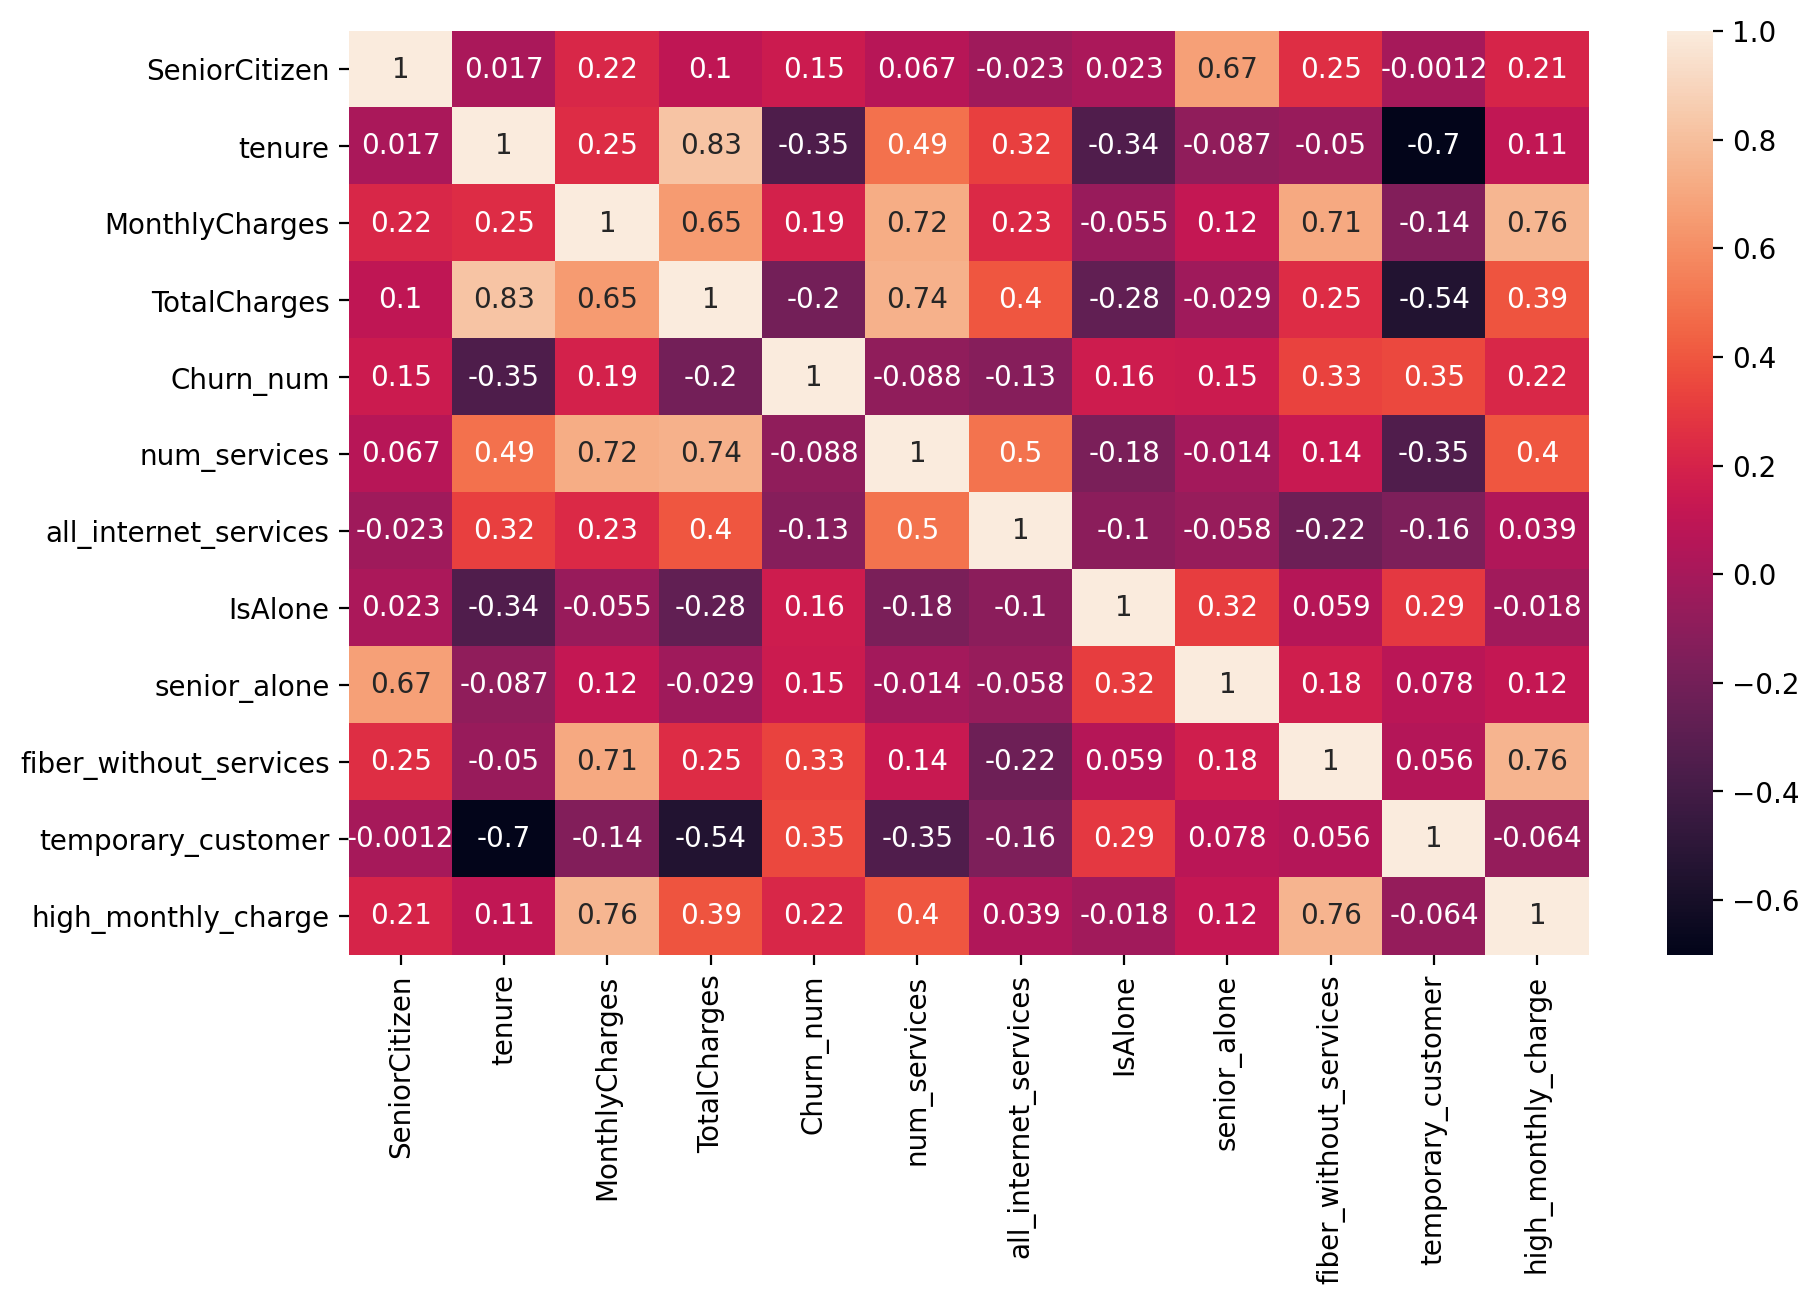

In [59]:
# Посмотрим корреляцию 
plt.figure(figsize=(10, 6), dpi=200)
sns.heatmap(churn_df.corr(), annot=True)

## 4. Подготовка данных к моделированию

In [60]:
X = churn_df.drop(['Churn', 'Churn_num', 'customerID'], axis=1)
y = churn_df['Churn_num']

In [61]:
X.head()

gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   
2    Male              0      No         No       2          Yes   
3    Male              0      No         No      45           No   
4  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  ...  \
0  No phone service             DSL             No          Yes  ...   
1                No             DSL            Yes           No  ...   
2                No             DSL            Yes          Yes  ...   
3  No phone service             DSL            Yes           No  ...   
4                No     Fiber optic             No           No  ...   

  MonthlyCharges TotalCharges tenure_group num_services all_internet_services  \
0          29.85        29.85          new            1                     0   
1          56.95      1889.50         2-3y            2                     0   
2          53.85       108.15         1-6m            2                     0   
3          42.30      1840.75         3-4y            3                     0   
4          70.70       151.65         1-6m            0                     0   

  IsAlone senior_alone  fiber_without_services  temporary_customer  \
0       0            0                       0                   1   
1       1            0                       0                   0   
2       1            0                       0                   1   
3       1            0                       0                   0   
4       1            0                       1                   1   

  high_monthly_charge  
0                   0  
1                   0  
2                   0  
3                   0  
4                   1  

[5 rows x 27 columns]

In [62]:
from sklearn.model_selection import train_test_split

In [63]:
# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [64]:
X.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'tenure_group', 'num_services',
       'all_internet_services', 'IsAlone', 'senior_alone',
       'fiber_without_services', 'temporary_customer', 'high_monthly_charge'],
      dtype='object')

### 4.1 Создание пайплайна препроцессинга

In [65]:
# Классификация признаков
cat_features = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'tenure_group'] # Категориальные признаки которые нужно превратить в дамми 
bin_features = ['SeniorCitizen', 'all_internet_services', 'IsAlone', 'fiber_without_services', 'temporary_customer', 'high_monthly_charge','senior_alone'] # Категориальные переменные которые уже равны 0 или 1 и их не нужно превращать в дамми 
num_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'num_services'] # Непрерывные признаки 

In [66]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [67]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features), # Масштабирование числовых
        ('cat', OneHotEncoder(drop='first', sparse=False), cat_features), # OneHotEncoding для категориальных
        ('bin', 'passthrough', bin_features) # Бинарные оставляем как есть
])

In [68]:
X_train_processed = preprocessor.fit_transform(X_train) # Массив 
# Тк ColumnTransformer возвращает массив, возьмем имена каждого столбца и выведем датафрейм 
feature_names = preprocessor.get_feature_names_out() # Получаем названия колонок
X_train_processed = pd.DataFrame(X_train_processed, columns=feature_names, index=X_train.index) # Датафрейм
X_train_processed

num__tenure  num__MonthlyCharges  num__TotalCharges  num__num_services  \
1695     0.881078             0.195927           0.654503           0.517373   
1095    -1.284263             0.522755          -0.974042          -0.560898   
3889    -0.793997            -1.509551          -0.894986          -1.100034   
3667    -0.344587             1.053643          -0.010497           0.517373   
2902    -1.079985             0.308740          -0.810567          -0.560898   
...           ...                  ...                ...                ...   
3772    -1.284263             1.002213          -0.967664           0.517373   
5191    -0.385442             0.872809          -0.039254           2.134781   
5226    -0.834852            -1.448167          -0.874505          -1.100034   
5390    -0.834852             1.149866          -0.479844           0.517373   
860     -0.262876            -1.492960          -0.807742          -1.100034   

      cat__gender_Male  cat__Partner_Yes  cat__Dependents_Yes  \
1695               1.0               1.0                  1.0   
1095               1.0               0.0                  0.0   
3889               1.0               0.0                  0.0   
3667               0.0               1.0                  1.0   
2902               0.0               0.0                  0.0   
...                ...               ...                  ...   
3772               1.0               1.0                  0.0   
5191               0.0               1.0                  1.0   
5226               1.0               1.0                  1.0   
5390               1.0               0.0                  0.0   
860                1.0               0.0                  0.0   

      cat__PhoneService_Yes  cat__MultipleLines_No phone service  \
1695                    1.0                                  0.0   
1095                    1.0                                  0.0   
3889                    1.0                                  0.0   
3667                    1.0                                  0.0   
2902                    1.0                                  0.0   
...                     ...                                  ...   
3772                    1.0                                  0.0   
5191                    1.0                                  0.0   
5226                    1.0                                  0.0   
5390                    1.0                                  0.0   
860                     1.0                                  0.0   

      cat__MultipleLines_Yes  ...  cat__tenure_group_5-6y  \
1695                     1.0  ...                     0.0   
1095                     0.0  ...                     0.0   
3889                     0.0  ...                     0.0   
3667                     0.0  ...                     0.0   
2902                     0.0  ...                     0.0   
...                      ...  ...                     ...   
3772                     0.0  ...                     0.0   
5191                     1.0  ...                     0.0   
5226                     0.0  ...                     0.0   
5390                     1.0  ...                     0.0   
860                      0.0  ...                     0.0   

      cat__tenure_group_6-12m  cat__tenure_group_new  bin__SeniorCitizen  \
1695                      0.0                    0.0                 0.0   
1095                      0.0                    1.0                 0.0   
3889                      0.0                    0.0                 0.0   
3667                      0.0                    0.0                 1.0   
2902                      0.0                    0.0                 1.0   
...                       ...                    ...                 ...   
3772                      0.0                    1.0                 0.0   
5191                      0.0                    0.0                 0.0   
5226                      1.0 

In [69]:
# Для тестовых данных просто transform чтобы избежать утечки данных 
X_test_processed = preprocessor.transform(X_test)
feature_names = preprocessor.get_feature_names_out()
X_test_processed = pd.DataFrame(X_test_processed, columns=feature_names, index=X_test.index)
X_test_processed

num__tenure  num__MonthlyCharges  num__TotalCharges  num__num_services  \
185     -1.284263            -1.327058          -0.998650          -1.100034   
2715     0.349957            -1.312127          -0.569758          -1.100034   
3825     0.799367            -1.507892          -0.554199          -1.100034   
1807    -1.284263             0.383397          -0.975896          -0.560898   
132      1.412199            -0.472660           0.429431          -0.560898   
...           ...                  ...                ...                ...   
5522    -1.284263             0.177678          -0.978633          -1.100034   
6377    -1.284263            -0.668425          -0.989888           0.517373   
5500     1.126211            -0.142514           0.621155           0.517373   
2392    -0.508008             0.859537          -0.223299          -0.021762   
6705    -0.426298            -0.454411          -0.465388          -0.560898   

      cat__gender_Male  cat__Partner_Yes  cat__Dependents_Yes  \
185                0.0               1.0                  0.0   
2715               1.0               0.0                  0.0   
3825               0.0               1.0                  1.0   
1807               0.0               0.0                  0.0   
132                1.0               0.0                  0.0   
...                ...               ...                  ...   
5522               0.0               0.0                  0.0   
6377               1.0               0.0                  0.0   
5500               1.0               1.0                  1.0   
2392               1.0               0.0                  0.0   
6705               1.0               1.0                  1.0   

      cat__PhoneService_Yes  cat__MultipleLines_No phone service  \
185                     0.0                                  1.0   
2715                    1.0                                  0.0   
3825                    1.0                                  0.0   
1807                    1.0                                  0.0   
132                     1.0                                  0.0   
...                     ...                                  ...   
5522                    1.0                                  0.0   
6377                    0.0                                  1.0   
5500                    1.0                                  0.0   
2392                    1.0                                  0.0   
6705                    1.0                                  0.0   

      cat__MultipleLines_Yes  ...  cat__tenure_group_5-6y  \
185                      0.0  ...                     0.0   
2715                     1.0  ...                     0.0   
3825                     0.0  ...                     0.0   
1807                     0.0  ...                     0.0   
132                      0.0  ...                     1.0   
...                      ...  ...                     ...   
5522                     0.0  ...                     0.0   
6377                     0.0  ...                     0.0   
5500                     0.0  ...                     0.0   
2392                     1.0  ...                     0.0   
6705                     0.0  ...                     0.0   

      cat__tenure_group_6-12m  cat__tenure_group_new  bin__SeniorCitizen  \
185                       0.0                    1.0                 0.0   
2715                      0.0                    0.0                 0.0   
3825                      0.0                    0.0                 0.0   
1807                      0.0                    1.0                 0.0   
132                       0.0                    0.0                 0.0   
...                       ...                    ...                 ...   
5522                      0.0                    1.0                 0.0   
6377                      0.0                    1.0                 0.0   
5500                      0.0 

## 5. Построение и оценка моделей 
### 5.1 Сравнение базовых моделей 
Выполняем кросс-валидацию 5 моделей 

In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import cross_val_score

In [71]:
models = {'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced'), 
         'KNN': KNeighborsClassifier(weights='distance'), 
         'SVC': SVC(class_weight='balanced'), 
         'RandomForest': RandomForestClassifier(class_weight='balanced'), 
         'GradientBoosting': GradientBoostingClassifier()}

In [72]:
result_f1 = {}
result_auc = {}

for name, model in models.items():
    scores_f1 = cross_val_score(model, X_train_processed, y_train, cv=5, scoring='f1')
    result_f1[name] = scores_f1.mean()
    
    scores_auc = cross_val_score(model, X_train_processed, y_train, cv=5, scoring='roc_auc')
    result_auc[name] = scores_auc.mean()

In [73]:
print('F1-Scores:')
for name, score in result_f1.items():
    print(f'{name}: {score}')

print('\n')
    
print('AUC-ROC Scores:')
for name, score in result_auc.items():
    print(f'{name}: {score}')


F1-Scores:
LogisticRegression: 0.6139266823827685
KNN: 0.5244247055761004
SVC: 0.6206096992668761
RandomForest: 0.5343489491871732
GradientBoosting: 0.5661487085760288


AUC-ROC Scores:
LogisticRegression: 0.8437153797538942
KNN: 0.7769975516880605
SVC: 0.8245048939684427
RandomForest: 0.819024605269447
GradientBoosting: 0.8400779635992841


### Выводы и интерпретация метрик: 
### Выбор метрик: 
- accuracy не используем - бесполезен при дисбалансе, 
- F1-Score - баланс между Precision ("сколько из предсказанных реально уйдут") и Recall ("сколько уходящих находим")
- AUC-ROC - показывает, насколько хорошо модель отличает уходящих от остающихся

### Результаты моделей: 
LogisticRegression - лучшая (F1: 0,614, AUC: 0,844)

SVC - чуть лучше F1, но хуже AUC и медленнее

GradientBoosting - хороший AUC, но плохой F1

RandomForest - средние результаты

KNN - худшая из-за 44 признаков после OneHot

### 5.2 Тестирование LogisticRegression с подбором гиперпараметров 

In [79]:
from sklearn.model_selection import RandomizedSearchCV

In [80]:
param_dist_logreg = {
    'penalty': ['l1', 'l2', 'elasticnet'], 
    'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100],
    'class_weight': ['balanced', None], 
    'solver': ['liblinear', 'saga']
    
}

In [81]:
logreg = LogisticRegression(max_iter=1000)

In [83]:
random_search_logreg = RandomizedSearchCV(estimator=logreg, 
                                   param_distributions=param_dist_logreg, 
                                   n_iter=20,
                                   cv=5, 
                                   scoring='f1',
                                   random_state=42, 
                                   n_jobs=-1 
                                )

In [84]:
random_search_logreg.fit(X_train_processed, y_train)

C:\Anaconda\envs\ML_course\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
40 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Anaconda\envs\ML_course\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Anaconda\envs\ML_course\lib\site-packages\sklearn\linear_model\_logistic.py", line 1473, in fit
    % self.l1_ratio
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

--------------------------------------------------------------------------------
20 fits failed with the follow

RandomizedSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10,
                                              50, 100],
                                        'class_weight': ['balanced', None],
                                        'penalty': ['l1', 'l2', 'elasticnet'],
                                        'solver': ['liblinear', 'saga']},
                   random_state=42, scoring='f1')

In [85]:
random_search_logreg.best_params_

{'solver': 'liblinear', 'penalty': 'l2', 'class_weight': 'balanced', 'C': 5}

In [86]:
preds_logreg = random_search_logreg.predict(X_test_processed)

In [87]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [88]:
print(classification_report(y_test, preds_logreg))

              precision    recall  f1-score   support

           0       0.92      0.72      0.81      1539
           1       0.53      0.83      0.64       574

    accuracy                           0.75      2113
   macro avg       0.72      0.78      0.73      2113
weighted avg       0.81      0.75      0.76      2113



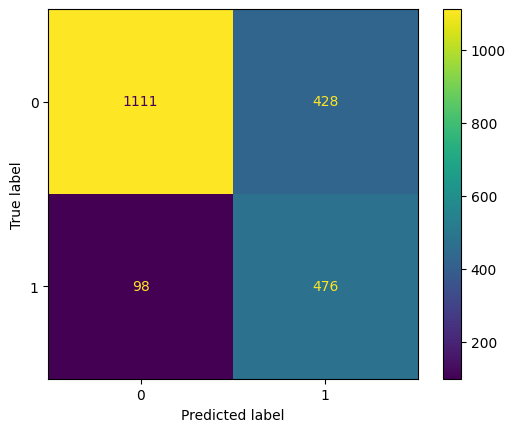

In [89]:
ConfusionMatrixDisplay.from_predictions(y_test, preds_logreg)
plt.show()

### Вывод: Модель находит 83% уходящих клиентов, но с низкой точностью - только 53% предсказанных реально уйдут. Это значит: чтобы удержать 476 клиентов, придется поработать с 904 (476 + 428) клиентами
### Для бизнеса: Приемлемый компромисс, но можно улучшить recall для удержания большего числа клиентов, пожертвовав точностью

### 5.3 Тестирование SVM с подбором гиперпараметров

In [90]:
from sklearn.model_selection import GridSearchCV

In [91]:
param_grid_svm = {
    'C': [0.1, 1, 10, 100],                  
    'kernel': ['linear', 'rbf'],               
    'gamma': ['scale', 'auto'],             
    'class_weight': ['balanced']              
}

In [92]:
svm = SVC(random_state=42, max_iter=1000)

In [93]:
grid_search_svm = GridSearchCV(
    estimator=svm,
    param_grid=param_grid_svm,
    cv=3,                                     
    scoring='f1',
    n_jobs=-1,
    verbose=1 # видеть прогресс
)

In [94]:
grid_search_svm.fit(X_train_processed, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


C:\Anaconda\envs\ML_course\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


GridSearchCV(cv=3, estimator=SVC(max_iter=1000, random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'class_weight': ['balanced'],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='f1', verbose=1)

In [95]:
grid_search_svm.best_params_

{'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}

In [96]:
preds_svm = grid_search_svm.predict(X_test_processed)

In [97]:
print(classification_report(y_test, preds_svm))

              precision    recall  f1-score   support

           0       0.88      0.65      0.75      1539
           1       0.45      0.76      0.57       574

    accuracy                           0.68      2113
   macro avg       0.67      0.71      0.66      2113
weighted avg       0.76      0.68      0.70      2113



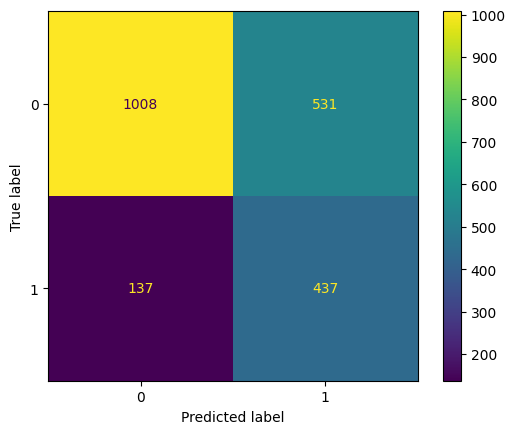

In [98]:
ConfusionMatrixDisplay.from_predictions(y_test, preds_svm)
plt.show()

### Вывод: SVM показывает худшие результаты, чем LogisticRegression, требует больше времени на обучение и не сошлась полностью. Не подходит для задачи оттока

### 5.4 Ансамбль моделей

In [99]:
from sklearn.ensemble import VotingClassifier

# Лучшие версии моделей
best_logreg = random_search_logreg.best_estimator_  
best_svm = grid_search_svm.best_estimator_   

# Ансамбль
ensemble_logreg_svm = VotingClassifier(
    estimators=[
        ('logreg', best_logreg),
        ('svm_rbf', best_svm)  
    ],
    voting='hard', 
    weights=[2, 1]  
)

In [100]:
ensemble_logreg_svm.fit(X_train_processed, y_train)

C:\Anaconda\envs\ML_course\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


VotingClassifier(estimators=[('logreg',
                              LogisticRegression(C=5, class_weight='balanced',
                                                 max_iter=1000,
                                                 solver='liblinear')),
                             ('svm_rbf',
                              SVC(C=10, class_weight='balanced', max_iter=1000,
                                  random_state=42))],
                 weights=[2, 1])

In [101]:
preds_ensemble = ensemble_logreg_svm.predict(X_test_processed)

In [102]:
print(classification_report(y_test, preds_ensemble))

              precision    recall  f1-score   support

           0       0.92      0.72      0.81      1539
           1       0.53      0.83      0.64       574

    accuracy                           0.75      2113
   macro avg       0.72      0.78      0.73      2113
weighted avg       0.81      0.75      0.76      2113



In [103]:
print(confusion_matrix(y_test, preds_ensemble))

[[1111  428]
 [  98  476]]


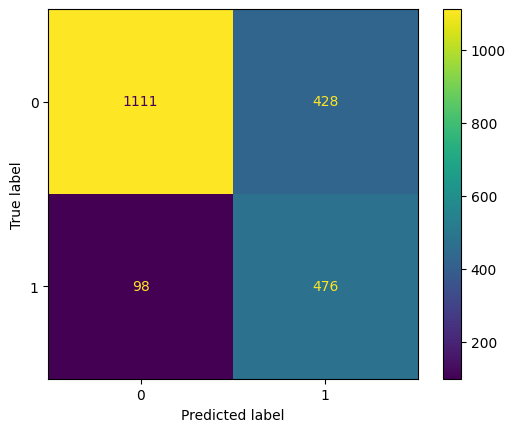

In [104]:
ConfusionMatrixDisplay.from_predictions(y_test, preds_ensemble)
plt.show()

### Вывод: Ансамбль не дает улучшения метрик по сравнению с одиночной LogisticRegression. Использование ансамбля в данном случае не оправдано

### 5.5 Тестирование XGBoost с подбором гиперпараметров 
#### 5.5.1 Базовый вариант с порогом 0.5

In [105]:
from xgboost import XGBClassifier

In [106]:
# scale_pos_weight для борьбы с дисбалансом
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
scale_pos_weight

2.806949806949807

In [107]:
xgb = XGBClassifier(
    random_state=42, 
    n_jobs = -1, 
    scale_pos_weight=scale_pos_weight
)

In [108]:
param_dist_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.5],
    'reg_lambda': [0.1, 1.0, 5.0],
    'reg_alpha': [0, 0.5, 1.0],
}

In [109]:
random_search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist_xgb, 
    n_iter=50, 
    cv=3, 
    scoring='recall', 
    random_state=42, 
    n_jobs=-1
)

In [ ]:
random_search_xgb.fit(X_train_processed, y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           predictor=None, random_state=42,
                                           reg_alpha=None, reg

In [112]:
random_search_xgb.best_params_

{'subsample': 0.8,
 'reg_lambda': 5.0,
 'reg_alpha': 1.0,
 'n_estimators': 200,
 'min_child_weight': 1,
 'max_depth': 3,
 'learning_rate': 0.01,
 'gamma': 0.5,
 'colsample_bytree': 0.7}

In [113]:
preds_xgb = random_search_xgb.predict(X_test_processed)

In [114]:
print(classification_report(y_test, preds_xgb))

              precision    recall  f1-score   support

           0       0.92      0.70      0.80      1539
           1       0.51      0.85      0.64       574

    accuracy                           0.74      2113
   macro avg       0.72      0.77      0.72      2113
weighted avg       0.81      0.74      0.75      2113



In [115]:
print(confusion_matrix(y_test, preds_xgb))

[[1077  462]
 [  88  486]]


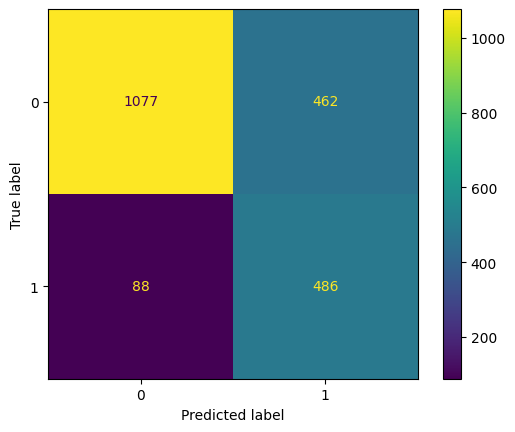

In [116]:
ConfusionMatrixDisplay.from_predictions(y_test, preds_xgb)
plt.show()

### Вывод: Стандартный порог дает сбалансированные результаты: 85% recall, 51% precision. Хорошо, но можно улучшить recall для удержания

#### 5.5.2 Экстремальный вариант: порог 0.3 (максимальный recall)

In [117]:
preds_proba_xgb = random_search_xgb.predict_proba(X_test_processed)[:, 1]

In [118]:
threshold = 0.3
preds_xgb_extreme = (preds_proba_xgb > threshold).astype(int)

In [119]:
print(classification_report(y_test, preds_xgb_extreme))

              precision    recall  f1-score   support

           0       0.97      0.45      0.61      1539
           1       0.39      0.96      0.56       574

    accuracy                           0.59      2113
   macro avg       0.68      0.70      0.59      2113
weighted avg       0.81      0.59      0.60      2113



In [120]:
print(confusion_matrix(y_test, preds_xgb_extreme))

[[691 848]
 [ 23 551]]


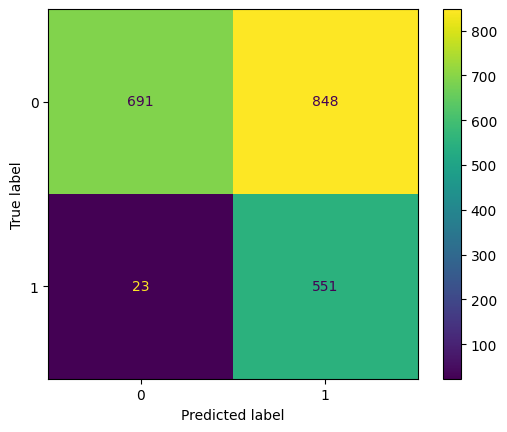

In [121]:
ConfusionMatrixDisplay.from_predictions(y_test, preds_xgb_extreme)
plt.show()

### Вывод: Находим почти всех уходящих (96%), но precision падает до 39% - слишком много ложных срабатываний

#### 5.5.3 Анализ ROC и Precision-Recal кривых

In [122]:
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve

C:\Anaconda\envs\ML_course\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


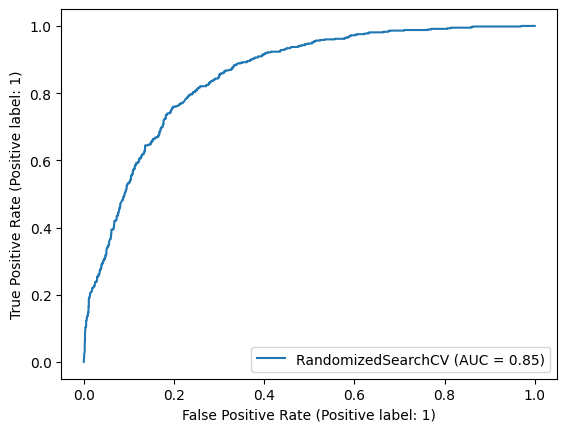

In [123]:
plot_roc_curve(random_search_xgb, X_test_processed, y_test)

In [124]:
from sklearn.metrics import roc_curve
preds_proba_xgb = random_search_xgb.predict_proba(X_test_processed)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, preds_proba_xgb)
best_idx = np.argmax(tpr - fpr)  
best_threshold = thresholds[best_idx]

print(f"Лучший порог: {best_threshold}")
print(f"Recall (TPR) при этом: {tpr[best_idx]}")
print(f"FPR при этом: {fpr[best_idx]}")

Лучший порог: 0.5446550846099854
Recall (TPR) при этом: 0.8205574912891986
FPR при этом: 0.25795971410006496


### Вывод:
ROC кривая: AUC = 0.88 - модель отлично разделяет классы

Оптимальный порог по ROC: 0.545
- Recall: 0.82, FPR: 0.258
- Баланс между обнаружением и ложными срабатываниями

C:\Anaconda\envs\ML_course\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


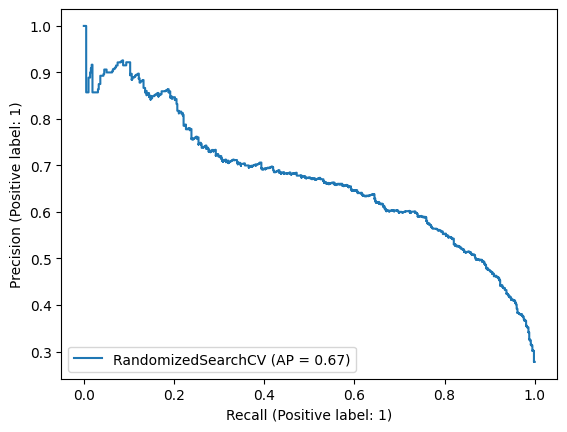

In [125]:
plot_precision_recall_curve(random_search_xgb, X_test_processed, y_test)

In [128]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds_pr = precision_recall_curve(y_test, preds_proba_xgb)

results = pd.DataFrame({
    'Порог': thresholds_pr,
    'Precision': precision[:-1],
    'Recall': recall[:-1]
})

In [129]:
results[(results['Recall'] > 0.86) & (results['Precision'] > 0.50)].sort_values('Recall', ascending=False).head(10)

Порог  Precision    Recall
845  0.475473   0.500502  0.869338
847  0.475817   0.501508  0.869338
846  0.475540   0.501004  0.869338
848  0.475923   0.501511  0.867596
849  0.477931   0.502016  0.867596
850  0.478627   0.503539  0.867596
851  0.478864   0.504049  0.867596
852  0.479012   0.504559  0.867596
853  0.479053   0.505071  0.867596
854  0.479378   0.505584  0.867596

### Вывод: Оптимальный порог для задачи: 0.475473

Recall: 0.87 - находим 87% уходящих клиентов

Precision: 0.50 - каждый второй предсказанный реально уйдет

Идеальный компромисс для удержания: максимум найденных уходящих при разумных ложных срабатываниях

Выбор порога 0.475 обоснован: Для задачи удержания клиентов важнее найти как можно больше уходящих (высокий recall), чем минимизировать ложные срабатывания

#### 5.5.4 Оптимальный порог: 0.475473

In [130]:
preds_proba_xgb = random_search_xgb.predict_proba(X_test_processed)[:, 1]
threshold = 0.475473

In [132]:
preds_xgb_best = (preds_proba_xgb > threshold).astype(int)
preds_xgb_best

array([1, 0, 0, ..., 0, 1, 0])

In [133]:
print(classification_report(y_test, preds_xgb_best))

              precision    recall  f1-score   support

           0       0.93      0.68      0.78      1539
           1       0.50      0.87      0.64       574

    accuracy                           0.73      2113
   macro avg       0.72      0.77      0.71      2113
weighted avg       0.82      0.73      0.74      2113



In [134]:
print(confusion_matrix(y_test, preds_xgb_best))

[[1042  497]
 [  75  499]]


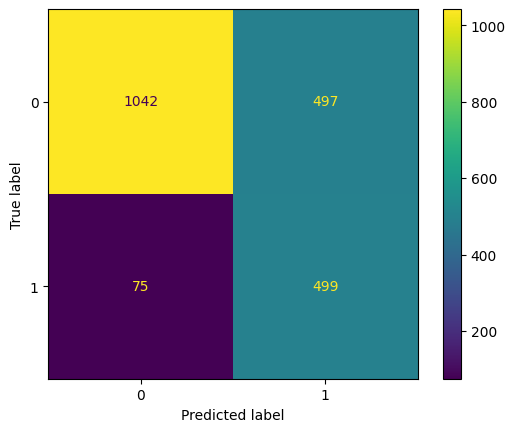

In [136]:
ConfusionMatrixDisplay.from_predictions(y_test, preds_xgb_best)
plt.show()

### Финальные результаты: XGBoost с порогом 0.475 находит 87% уходящих клиентов (recall 0.87), при этом 50% предсказанных реально уйдут (precision 0.50). Идеальный баланс для задачи удержания: максимум найденных уходящих при разумных ложных срабатываниях.

## 6. Анализ важности признаков (Feature Importance)

In [137]:
importance = random_search_xgb.best_estimator_.feature_importances_
features = X_train_processed.columns

In [138]:
feature_importance_df = pd.DataFrame({'Признак': features, 'Важность': importance})

In [139]:
top_features = feature_importance_df.sort_values('Важность', ascending=False).head(15)

In [140]:
top_features

Признак  Важность
41                    bin__temporary_customer  0.163854
25                     cat__Contract_Two year  0.148071
24                     cat__Contract_One year  0.099178
40                bin__fiber_without_services  0.076196
10           cat__InternetService_Fiber optic  0.050300
28        cat__PaymentMethod_Electronic check  0.043279
14      cat__OnlineBackup_No internet service  0.034314
34                     cat__tenure_group_5-6y  0.033127
0                                 num__tenure  0.032736
11                    cat__InternetService_No  0.032158
12    cat__OnlineSecurity_No internet service  0.030660
23                   cat__StreamingMovies_Yes  0.028028
16  cat__DeviceProtection_No internet service  0.025932
26                  cat__PaperlessBilling_Yes  0.021667
36                      cat__tenure_group_new  0.016995

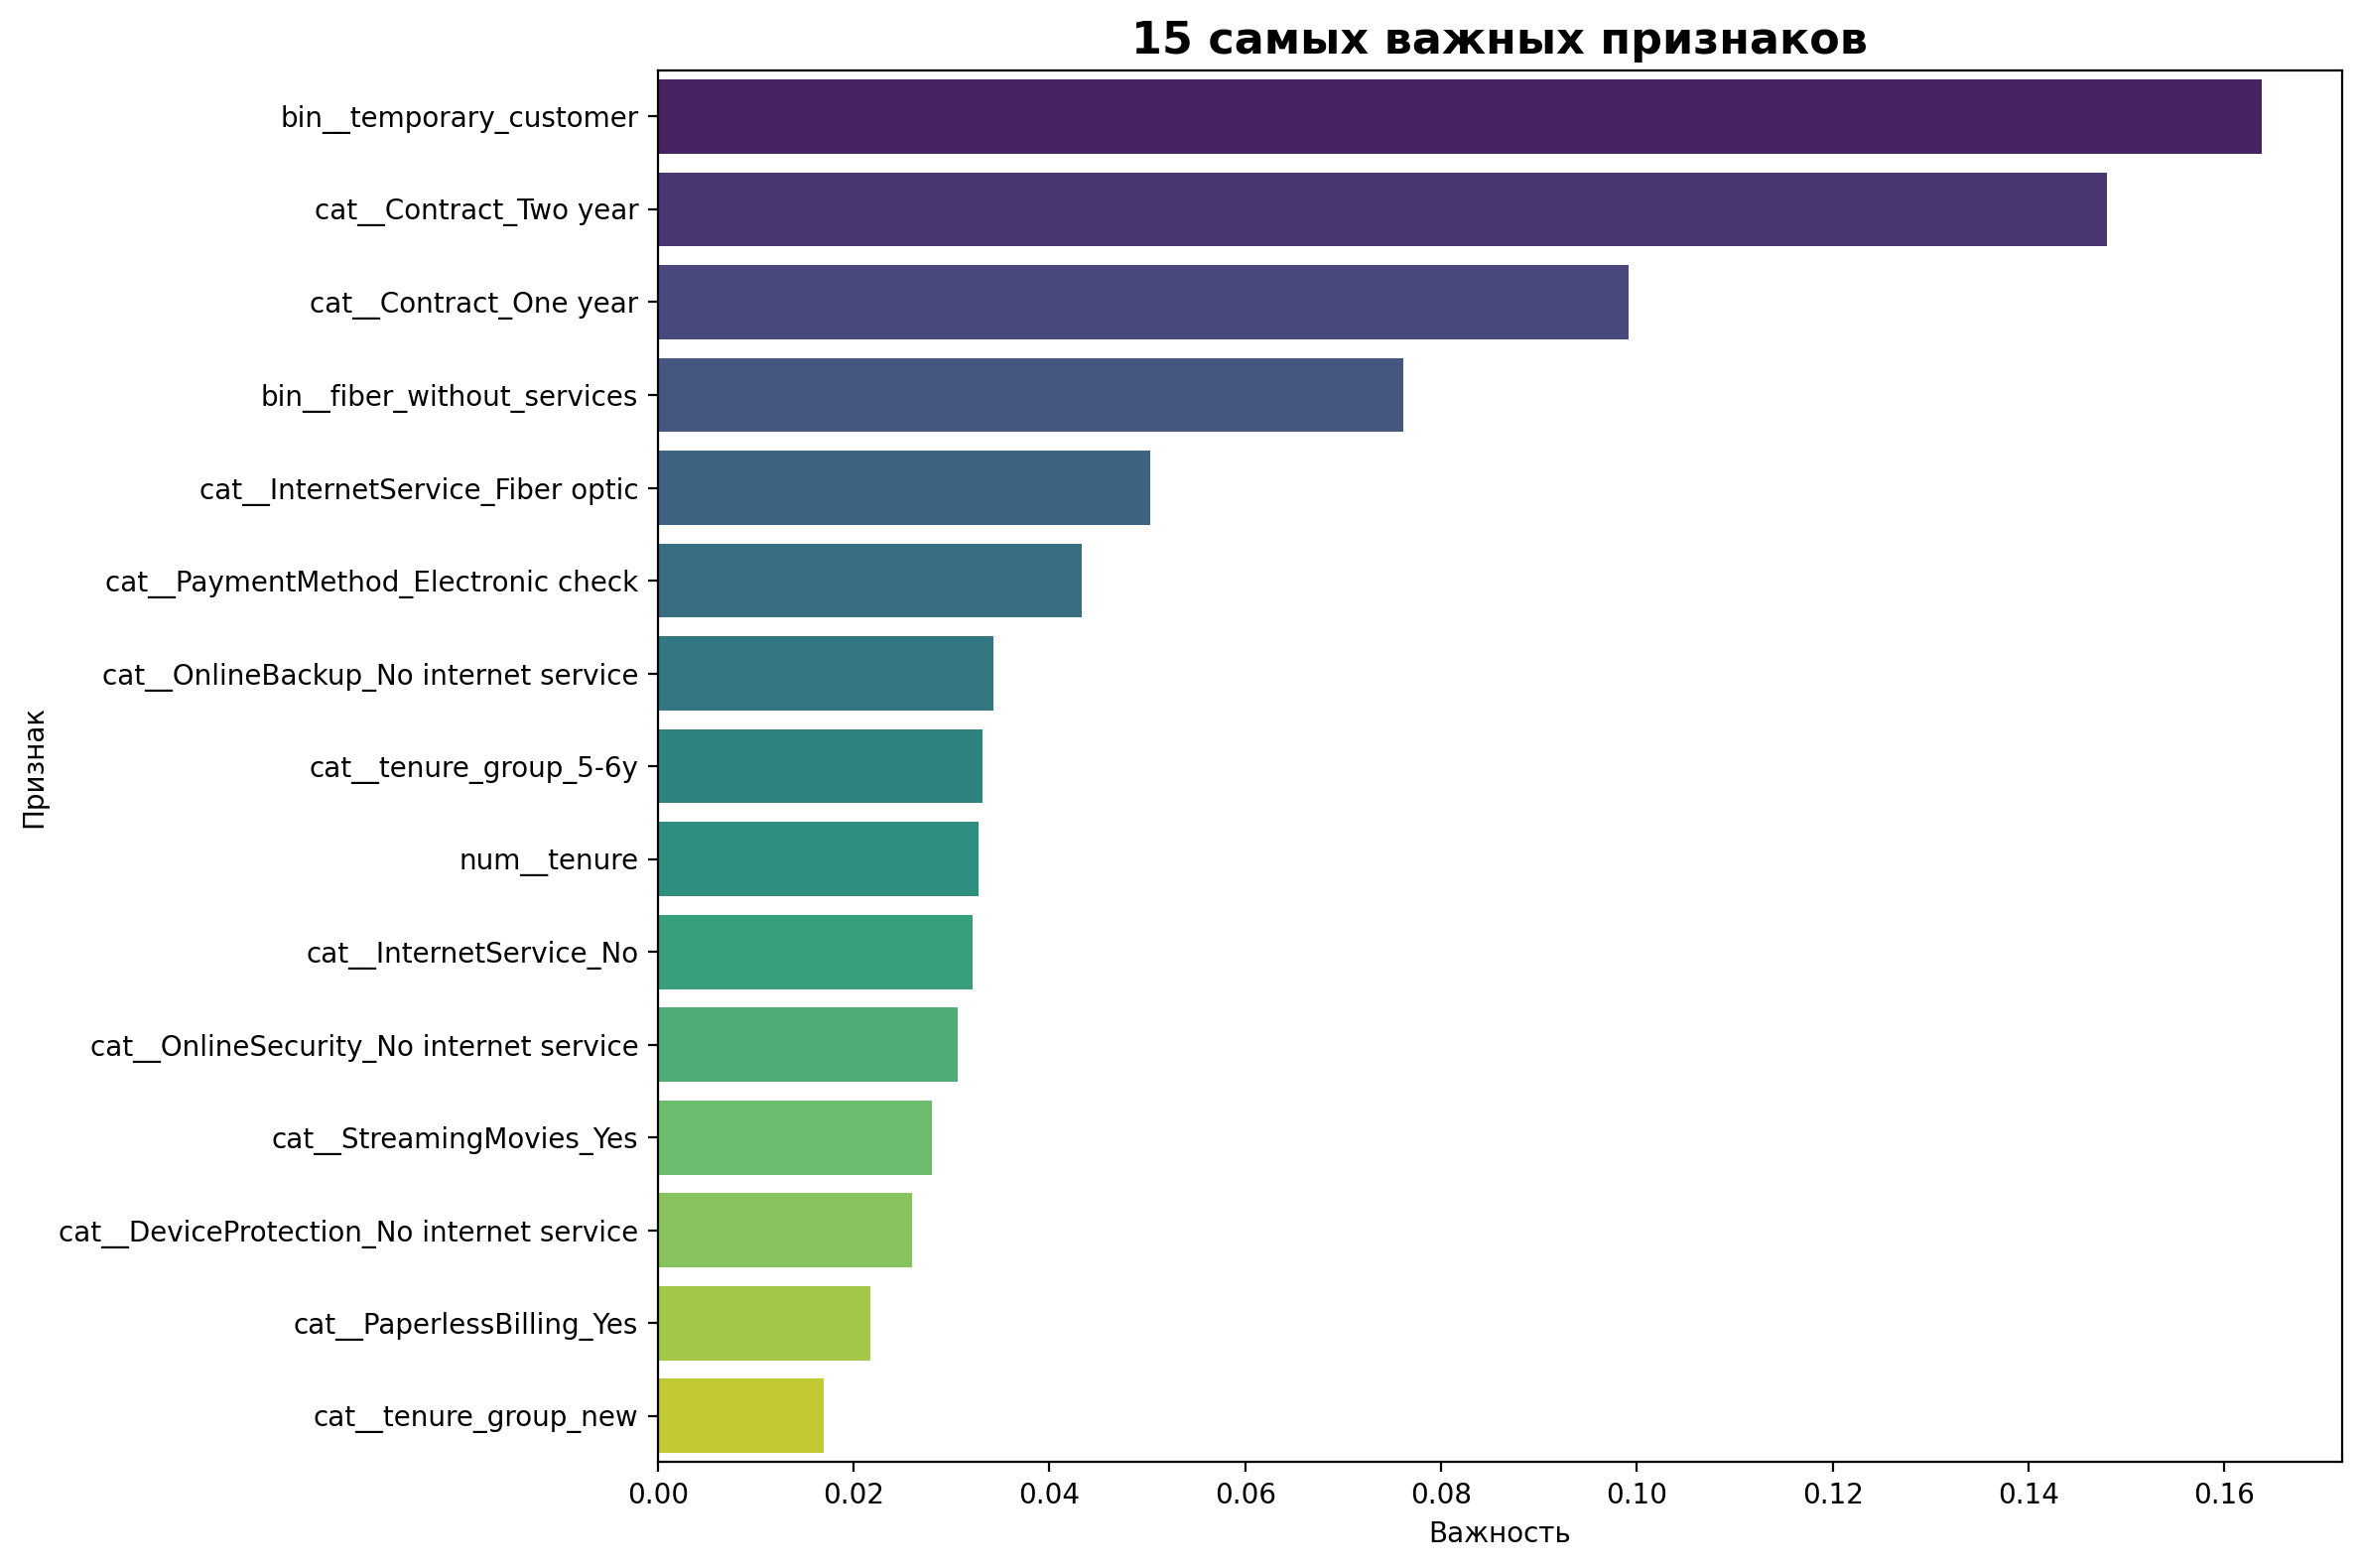

In [141]:
plt.figure(figsize=(12, 8), dpi=200)
sns.barplot(data=top_features, x='Важность', y='Признак', palette='viridis')
plt.title('15 самых важных признаков', fontweight='bold', fontsize=16)
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

### Результаты анализа важности признаков:  

#### **Топ 5 самых важных признаков:** 
1. `bin__temporary_customer` (0.164) - "временный клиент" (короткий tenure + помесячный контракт)
2. `cat__Contract_Two year` (0.148) - двухгодичный контракт 
3. `cat__Contract_One year` (0.099) - годичный контракт
4. `bin__fiber_without_services` (0.076) - Fiber optic без дополнительных услуг
5. `cat__InternetService_Fiber optic` (0.050) - интернет-провайдер Fiber optic


#### Ключевые выводы: 

Созданные признаки оказались самыми важными:

- `temporary_customer` - самый сильный предиктор оттока
- `fiber_without_services` - на 4-м месте


Тип контракта критически важен:
- Двухгодичный контракт снижает риск оттока
- Помесячный контракт (в составе temporary_customer) повышает риск
- Интернет-провайдер Fiber optic - значимый фактор риска

Неважные признаки:
- Пол (gender), пожилой пользователь или нет (SeniorCitizen) - минимальное влияние
- Стриминговые услуги - почти не влияют
- Созданные признаки all_internet_services, high_monthly_charge - нулевая важность

### Вывод: Feature engineering подтвердил свою ценность - созданные признаки вошли в топ-5 самых важных. Модель опирается на логичные бизнес-факторы: тип контракта, "временность" клиента, интернет-услуги.

## 7. Сохранение модели и результатов

In [142]:
import joblib

In [263]:
model_with_threshold = {
    'model': random_search_xgb.best_estimator_,
    'best_threshold': 0.475473,
    'preprocessor': preprocessor, 
    'feature_names': X_train_processed.columns.tolist()
}

In [265]:
joblib.dump(model_with_threshold, '../models/xgb_model.pkl')

['../models/xgb_model.pkl']

In [266]:
predictions_df = pd.DataFrame({
    'customer_id': X_test.index,
    'real_churn': y_test.values,
    'predicted_churn': y_pred_best,
    'churn_probability': proba
})

In [267]:
predictions_df.to_csv('../results/predictions.csv', index=False, encoding='utf-8')

In [146]:
importance_df = feature_importance_df.sort_values('Важность', ascending=False)

In [147]:
importance_df.to_csv('../results/importance.csv', index=False, encoding='utf-8')

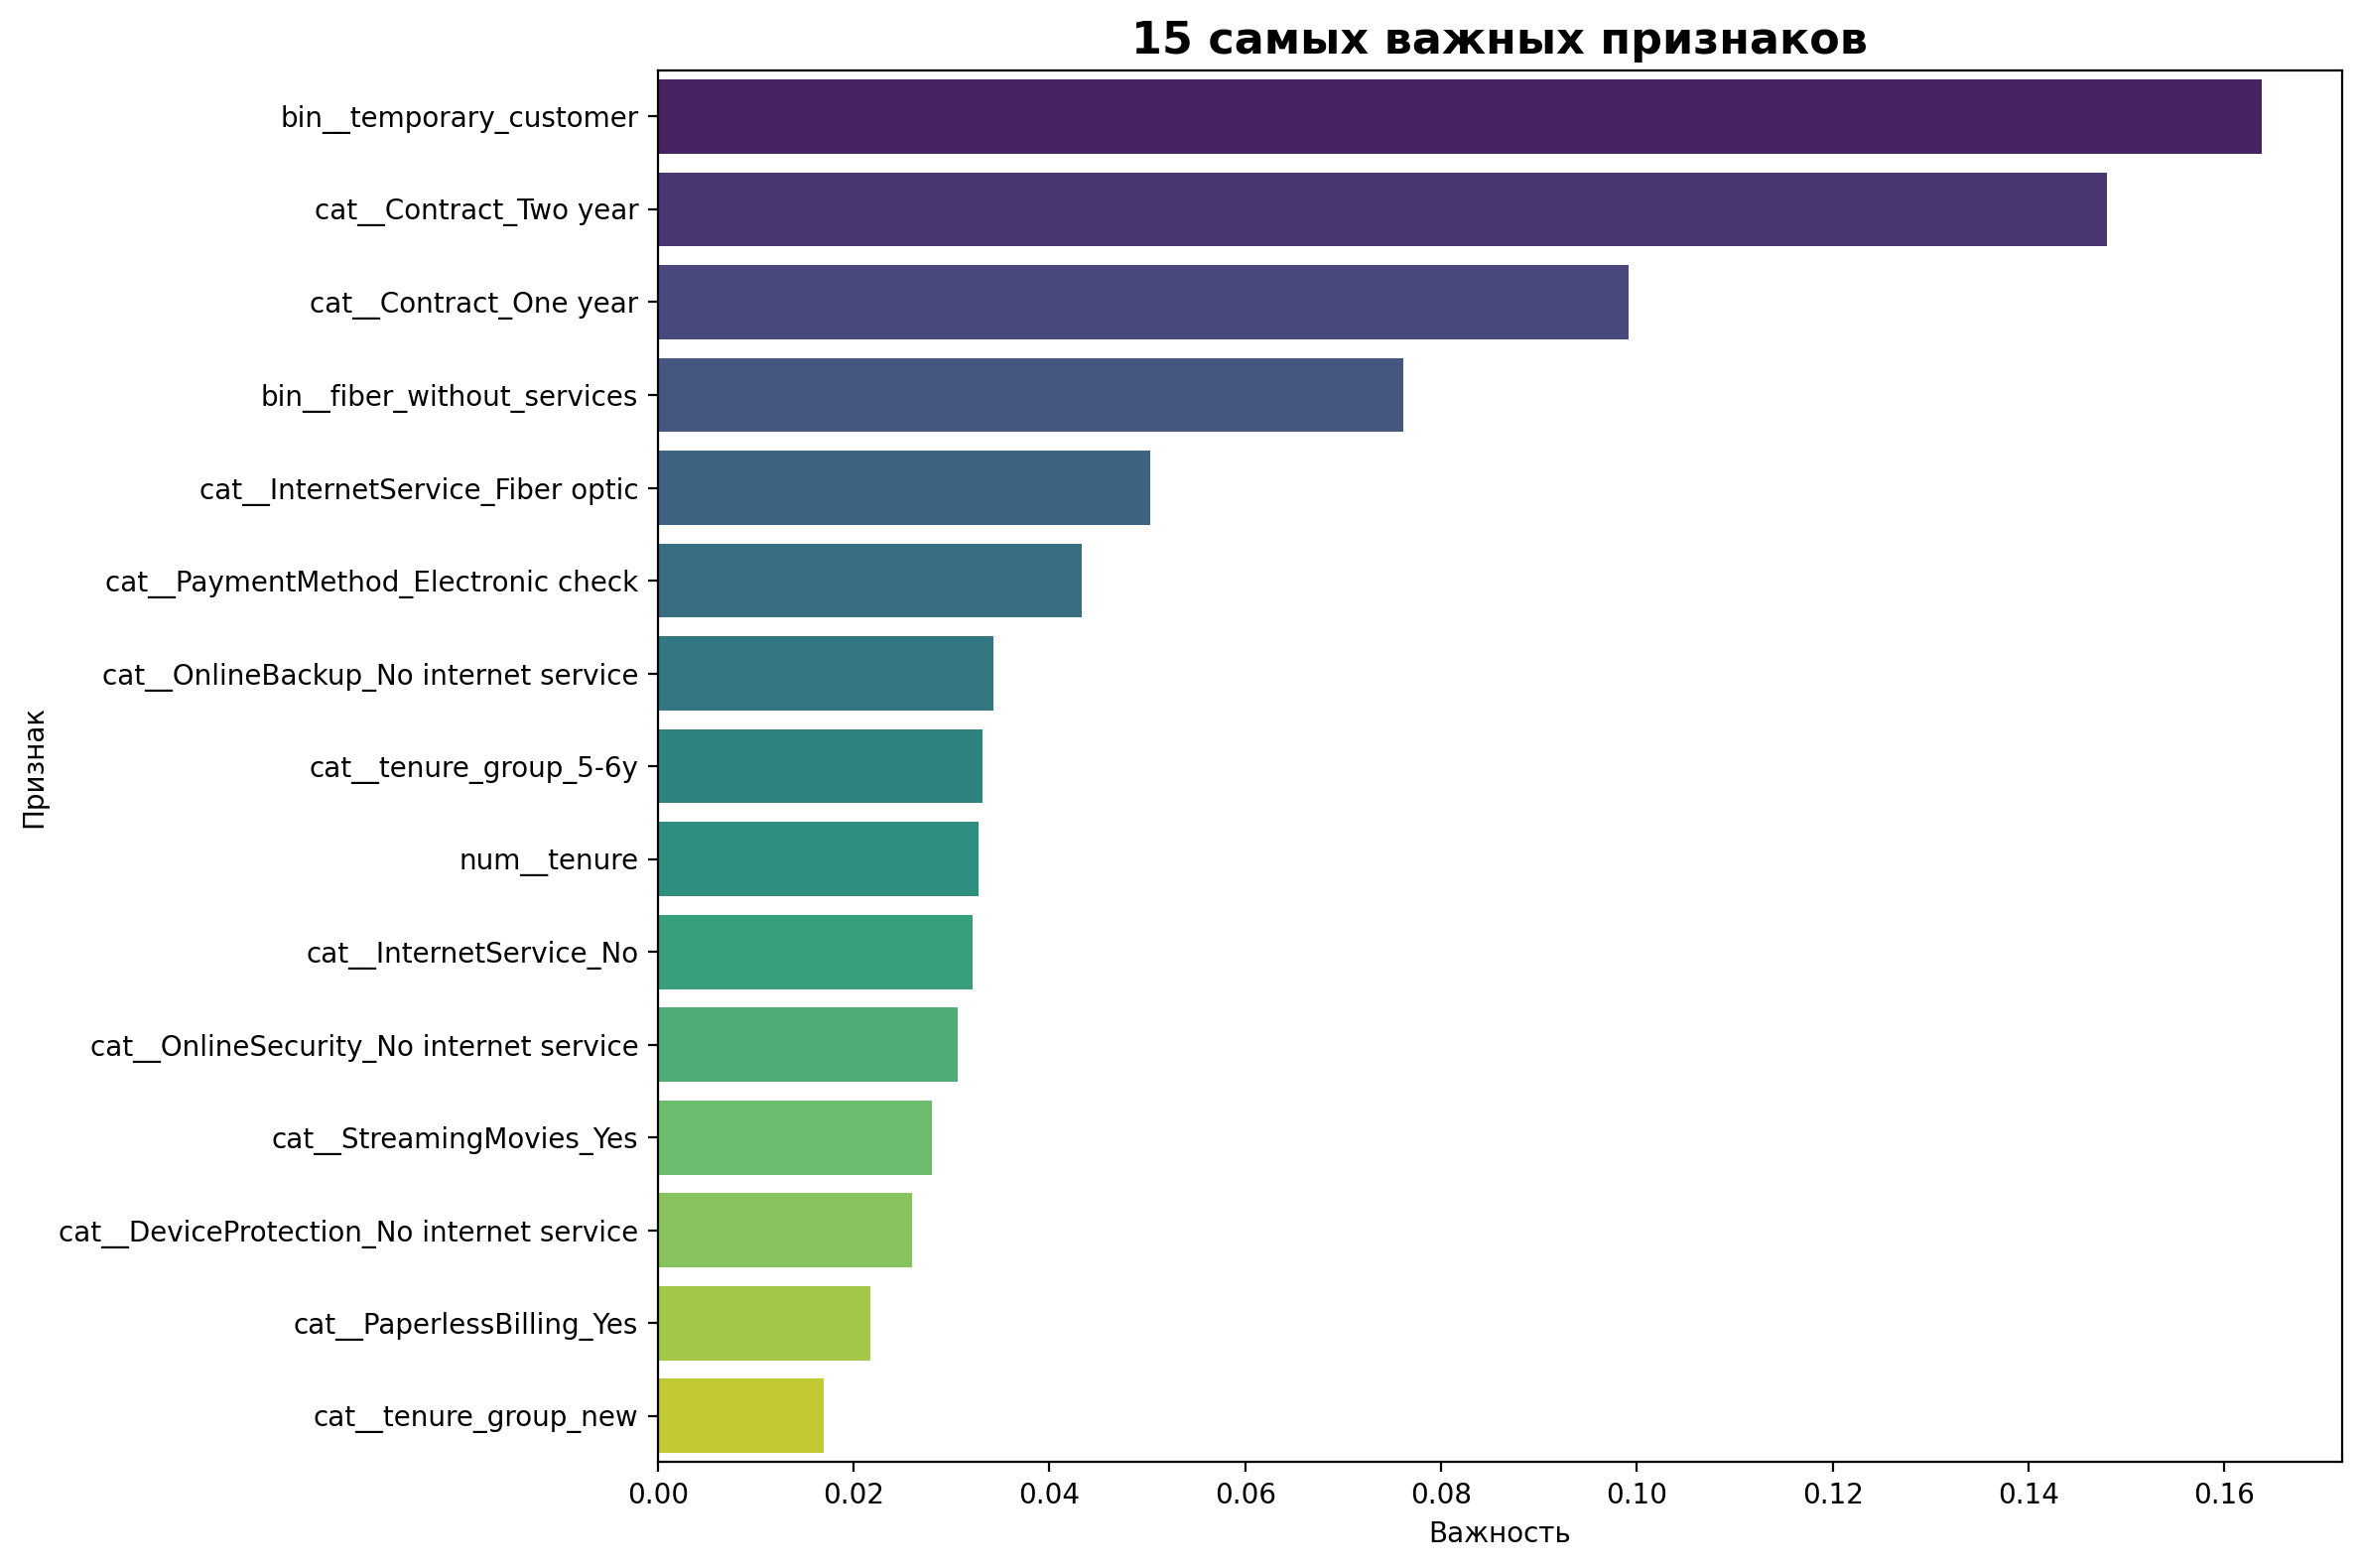

In [150]:
plt.figure(figsize=(12, 8), dpi=200)
sns.barplot(data=top_features, x='Важность', y='Признак', palette='viridis')
plt.title('15 самых важных признаков', fontweight='bold', fontsize=16)
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.tight_layout()

plt.savefig('../results/feature_importance_plot.png', dpi=200, bbox_inches='tight')

plt.show()